In [31]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import cdflib
from scipy.interpolate import RBFInterpolator

#Use this to ignore warning in inerpolation script, maybe get rid of later to check for other issues
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

pd.set_option('display.max_columns', None) #Change settings in Pandas so it shows all columns

In [32]:
#Constants
R = 8.314 #kgm^2s^-2K^-1mol^-1
h = 30 #Measurement height in m
L = 2.5*10**3 #Latent heat of vapoization of water at 0 deg C [J/g], should try to calc based on dependency on C
cp = 1005 #J/kg*K
mm = 0.02896 #kg/mol molar mass dry air
mm_w = 18.01 # molar mass of water [g/mol]
CtoK = 273.15 #Conversion from Celcius to Kelvin

In [33]:
#Read in tower coords and set up dataframe
tc = pd.read_csv('../Misc_data/tower_coords.csv') #datafrane of tower coordinates
tc.set_index('Tower', inplace = True)

#Convert lat and lon to coordinates in km, origin currently set to PFA coordinates, should change this since PFk is out of range
tc['x'] = (tc.Lon - tc.Lon['PFA'])*111*np.cos(tc.Lat['PFA']*np.pi/180)
tc['y'] = (tc.Lat - tc.Lat['PFA'])*111 


In [34]:
#Functions

#Func to convert RH to H2O concentration
def H2O_calc(TA, RH):
    
    #Convert T from Celcius to Kelvin
    TA_K= TA + CtoK #Temperature [K]

    es = 611.2*np.exp(17.67*(TA_K-CtoK)/(TA_K)) #Saturation vapor pressure [Pa] - Petty eqn 7.19 (pg 183)
    e = es*RH/100 #Vapor pressure [Pa]
    H2O = e/TA_K/R*mm_w #Water vapor concentration [g/m^3]
    return H2O




#Interpolate TA at 2, 10, and 30 m

def interpfun(data):
    
    #N, S, E, W coords (in km)
    tc['y_N'] = tc['y'] + 1
    tc['y_S'] = tc['y'] - 1
    tc['x_E'] = tc['x'] + 1
    tc['x_W'] = tc['x'] - 1

    #Make a 2D array with x and y values for location of each tower
    ar = np.array([tc.y.values, tc.x.values]).T
    
    #3D arrays of locations 1km up and down wind of each tower 
    #Dims are tower, time, and direction (x/y)
    N_coords = np.stack((tc.x.values, tc.y_N.values)).T
    S_coords = np.stack((tc.x.values, tc.y_S.values)).T
    E_coords = np.stack((tc.x_E.values, tc.y.values)).T
    W_coords = np.stack((tc.x_W.values, tc.y.values)).T


    #Create dataframes to hold interpolated data at N, S, E, and W points
    dat_N =pd.DataFrame(index = data.index, columns = data.columns)
    dat_S =pd.DataFrame(index = data.index, columns = data.columns)
    dat_E =pd.DataFrame(index = data.index, columns = data.columns)
    dat_W =pd.DataFrame(index = data.index, columns = data.columns)


    
    for i in data.index:
        dat_use = data.loc[data.index == i].values[0, :] #For each loop interpolate with just one row of data
        nanmask = np.isfinite(dat_use)

        if sum(nanmask)<10:
            #Set N, S, E, W datapoints to nans if less than 10 (need to decide how to chose this number) values are available
            
            dat_N.loc[dat_N.index ==i] = np.nan# dat_S.loc[dat_S.index ==i] = dat_E.loc[dat_E.index ==i] = dat_W.loc[dat_W.index ==i] = np.nan;
            

        else:
            dat_nn = dat_use[nanmask] #dat_use without nan values
            ar_nn = ar[nanmask] #coordinates of towers that have finite values
            # N_coords_nn = N_coords[nanmask]
            dat_N.loc[dat_N.index ==i] = RBFInterpolator(ar_nn, dat_nn)(N_coords)
            dat_S.loc[dat_S.index ==i] = RBFInterpolator(ar_nn, dat_nn)(S_coords)
            dat_E.loc[dat_E.index ==i] = RBFInterpolator(ar_nn, dat_nn)(E_coords)
            dat_W.loc[dat_W.index ==i] = RBFInterpolator(ar_nn, dat_nn)(W_coords)
            
    return dat_N, dat_S, dat_E, dat_W



# Plot profiles 

#profile_plot(30_m_data, 10_m_data, 2_m_data, folder_for_plot_storage, x_axis_range)

def profile_plot(data_1, data_2, data_3, folder, x_range = [-4, 4]):
    data_mon_1 = data_1.groupby([data_1.index.month, data_1.index.time]).mean()
    data_mon_2 = data_2.groupby([data_2.index.month, data_2.index.time]).mean()
    data_mon_3 = data_3.groupby([data_3.index.month, data_3.index.time]).mean()
    
    
    
    for tower in tc.index:
        
        if towdat.z3 == 0:
            pass
        
        else:

            fig, axs = plt.subplots(12, 4, figsize = (10, 30))
            for mon in range(6, 11):
                i=0
                for hour in data_mon_1.index.get_level_values(1).drop_duplicates():
                    ax = axs[i//4, i%4]
                    i= i+1
                    
                    dif_top = data_mon_1.loc[(mon, hour), tower] - data_mon_2.loc[(mon, hour), tower]
                    dif_bottom = data_mon_3.loc[(mon, hour), tower] - data_mon_2.loc[(mon, hour), tower]
                    # dif_bottom = data_mon[mon][hour][tower] - data_mon[mon][hour]tower]

                    # ax.plot([df_mon.TA_1_1_1[mon][hour], df_mon.TA_1_2_1[mon][hour],df_mon.TA_1_3_1[mon][hour]], [towdat.z1, towdat.z2, towdat.z3])
                    ax.plot([dif_top, 0, dif_bottom], [towdat.z1, towdat.z2, towdat.z3])
                    ax.set_yticks([towdat.z3, towdat.z2, towdat.z1])
                    ax.set_title(hour)
                    ax.set_xlim(x_range)

            fig.suptitle(tower)
            plt.tight_layout()
            plt.savefig(str('./Outputs/diff_Profiles/Interp_dirs/' + folder + '/' +tower + '_TA_diff_profiles'))


In [7]:
# #Collect data at 2, 10, and 30m for each tower

                                 
# #Get dates to use as index from PFb data
# filepath_i = tc.org_path['PFb'] #i for index because I am just using this to set the index
# df_i

#Create empty dataframes for 2, 10, and 30 m
TA_2, TA_10, TA_30 = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
RH_2, RH_10, RH_30 = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
WS_top, WD, Ustar = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
PA_top = pd.DataFrame()


for tower in tc.index:
    #print(tower)
    towdat = tc.loc[tower] #Tower data
    filepath = towdat.org_path #Eventually use gap-filled data for top level
    df = pd.read_csv(filepath)
    df = df.applymap(lambda x: np.nan if x == -9999 else x)
    
    
    if tower == 'PFA': #Come back and get 30m data here later
        TA_2[tower], TA_10[tower] = np.nan, np.nan
        RH_2[tower], RH_10[tower] = np.nan, np.nan
        # WS_top[tower], WD[tower], Ustar[tower] = np.nan, np.nan, np.nan
        # PA_top = np.nan
        
        
        #Read in PFA data
        filepath = '../Misc_data/US-PFa_HR_201901010000_202001010000.csv' #This is hourly data -> need halfhourly to match up with other towers
        PFA = pd.read_csv(filepath)

        PFA = PFA.applymap(lambda x: np.nan if x == -9999 else x)
        
        
        #Add datetime index
        dt_ts = pd.to_datetime(PFA['TIMESTAMP_START'], format = '%Y%m%d%H%M') + dt.timedelta(minutes = 30) #half hour time stamp
        PFA.set_index(dt_ts, inplace = True)


        #Linear interpolate PFA data to 15 min and then use just min 15 and 45 timestamps
        PFA_interp = PFA.resample('15T').mean().interpolate()
        PFA_interp = PFA_interp[(PFA_interp.index.minute == 15) | (PFA_interp.index.minute == 45)]


        #Cut to fit dates for the rest of the Cheesehead sites
        startdate = dt.datetime(2019, 6, 1)
        enddate = dt.datetime(2019, 11, 1)
        PFA_interp = PFA_interp[startdate: enddate]

        #Shift timestamps by 15 min to line up with other data 
        Corrected_TS_start = PFA_interp.index - dt.timedelta(minutes = 15)
        PFA_interp.set_index(Corrected_TS_start, inplace = True)

        #Add PFA 30 m data to dfs
        TA_30['PFA'] = PFA_interp.TA_F_1_3_1 
        RH_30['PFA'] = PFA_interp.RH_1_3_1
        WS_top['PFA'] = PFA_interp.WS_1_3_1
        WD['PFA'] = PFA_interp.WD_1_3_1
        Ustar['PFA'] = PFA_interp.USTAR_1_3_1
        PA_top['PFA'] = PFA_interp.PA_1_1_1 #Figure out a way to fill in later, only have pressure at top of tower, maybe use average across other towers

        
    
    else:
        #Add datetime index
        dt_ts = pd.to_datetime(df['TIMESTAMP_START'], format = '%Y%m%d%H%M') 
        df.set_index(dt_ts, inplace = True)
        
        
        #Add wind data to dfs
        WS_top[tower] = df.WS_1_1_1
        WD[tower] = df.WD_1_1_1
        Ustar[tower] = df.USTAR_1_1_1
        PA_top[tower] = df.PA_1_1_1
        
        #Towers with only one level
        if towdat.z2 == towdat.z3 == 0:
            TA_10[tower],  TA_30[tower] = np.nan, np.nan
            TA_2[tower] = df.TA_1_1_1
            
            RH_10[tower],  RH_30[tower] = np.nan, np.nan
            RH_2[tower] = df.RH_1_1_1
            
            
        #Towers with two levels
        elif towdat.z3 == 0:
            TA_30[tower] = np.nan
            TA_2[tower] = df.TA_1_2_1
            TA_10[tower] = df.TA_1_1_1
            
            RH_30[tower] = np.nan
            RH_2[tower] = df.RH_1_2_1
            RH_10[tower] = df.RH_1_1_1
            
        #Towers with three levels    
        else:
            TA_30[tower] = df.TA_1_1_1
            TA_10[tower] = df.TA_1_2_1
            TA_2[tower] = df.TA_1_3_1
            
            RH_30[tower] = df.RH_1_1_1
            RH_10[tower] = df.RH_1_2_1
            RH_2[tower] = df.RH_1_3_1
            
            #For PFl, extrapolate 30m TA from 10 and 25m TA
            if tower == 'PFl':
                TA_30[tower] = df.TA_1_1_1 + (df.TA_1_1_1 - df.TA_1_2_1)/3 #/3 from 5/(25-10)
                RH_30[tower] = df.RH_1_1_1 + (df.RH_1_1_1 - df.RH_1_2_1)/3 #/3 from 5/(25-10)

                
                
#Convert RH to H2O concentration
H2O_2 = H2O_calc(TA_2, RH_2)
H2O_10 = H2O_calc(TA_10, RH_10)
H2O_30 = H2O_calc(TA_30, RH_30)



# #Add in PFA data after converting RH to H2O (because only H2O given in PFA dataset)

# #Import data
# filepath = '../Misc_data/US-PFa_HR_201901010000_202001010000.csv' #This is hourly data -> need halfhourly to match up with other towers
# PFA = pd.read_csv(filepath)

# PFA = PFA.applymap(lambda x: np.nan if x == -9999 else x)



In [36]:
#Interpolate TA and H2O
TA_2_N, TA_2_S, TA_2_E, TA_2_W = interpfun(TA_2)
TA_10_N, TA_10_S, TA_10_E, TA_10_W = interpfun(TA_10)
TA_30_N, TA_30_S, TA_30_E, TA_30_W = interpfun(TA_30)

H2O_2_N, H2O_2_S, H2O_2_E, H2O_2_W = interpfun(H2O_2)
H2O_10_N, H2O_10_S, H2O_10_E, H2O_10_W = interpfun(H2O_10)
H2O_30_N, H2O_30_S, H2O_30_E, H2O_30_W = interpfun(H2O_30)



In [38]:
#Calculate gradients
TA_30_NS = TA_30_N - TA_30_S
TA_10_NS = TA_10_N - TA_10_S
TA_2_NS = TA_2_N - TA_2_S

TA_30_EW = TA_30_E - TA_30_W
TA_10_EW = TA_10_E - TA_10_W
TA_2_EW = TA_2_E - TA_2_W


H2O_30_NS = H2O_30_N - H2O_30_S
H2O_10_NS = H2O_10_N - H2O_10_S
H2O_2_NS = H2O_2_N - H2O_2_S

H2O_30_EW = H2O_30_E - H2O_30_W
H2O_10_EW = H2O_10_E - H2O_10_W
H2O_2_EW = H2O_2_E - H2O_2_W

In [47]:
#Combine TA and H2O into one dataframe
#at some point check mesurement levels, might be 3m for one tower--how to handle?
TA_all = pd.concat([TA_2, TA_10, TA_30], keys = [2, 10, 30])
H2O_all = pd.concat([H2O_2, H2O_10, H2O_30], keys = [2, 10, 30])


#Combine all TA and H2O data into a single dataframe 

TA_NS = pd.concat([TA_2_NS, TA_10_NS, TA_30_NS], keys = [2, 10, 30])
TA_EW = pd.concat([TA_2_EW, TA_10_EW, TA_30_EW], keys = [2, 10, 30])

H2O_NS = pd.concat([H2O_2_NS, H2O_10_NS, H2O_30_NS], keys = [2, 10, 30])
H2O_EW = pd.concat([H2O_2_EW, H2O_10_EW, H2O_30_EW], keys = [2, 10, 30])

TA_int_all = pd.concat([TA_NS, TA_EW], keys = ['NS', 'EW'])
H2O_int_all = pd.concat([H2O_NS, H2O_EW], keys = ['NS', 'EW'])

#Combine wind data into single dataframe
wind_dat = pd.concat([WS_top, WD, Ustar], keys = ['WS_top', 'WD', 'Ustar'])

#Save TA, H2O, wind data in pickles
TA_all.to_pickle('./Outputs/TA_orig_all.pickle')
H2O_all.to_pickle('./Outputs/H2O_orig_all.pickle')
TA_int_all.to_pickle('./Outputs/TA_int_all.pickle')
H2O_int_all.to_pickle('./Outputs/H2O_int_all.pickle')
wind_dat.to_pickle('./Outputs/wind_dat.pickle')  
PA_top.to_pickle('./Outputs/PA_top.pickle')

    

In [309]:
def WS_top_calc(tower, d_rat = 0.65):
    k = 0.4 #
    
    #Measurement height (z1 for all towers except PFA)
    if tower == 'PFA':
        h_tow = tc.z3.loc[tower]
    else:
        h_tow = tc.z1.loc[tower]
        
    h_veg = tc.veg_h.loc[tower] #Vegetation height
    WS_calc = (Ustar[tower]/k)*np.log((h_tow - d_rat*h_veg)/0.1*h_veg)
    return WS_calc
    
def prof_calcs(tower, step = 0.1):
    towdat = tc.loc[tower] #Tower data
    
    #Step is step size to be used for integration
    k = 0.4 #Von Karmann constant
    h_veg = tc.veg_h.loc[tower] #vegetation height
    h_tow = tc.z1.loc[tower] #tower height
    z_range = np.arange(0, h_tow + step, step)
    z_m = 0.1*h_veg #momentum friction parameter
    
    d = 0.65*h_veg #zero plane displacement
    
    # d_mean = h_tow - z_m*np.exp(k*WS_top[tower]/Ustar[tower])#zero plane displacement, mean of val calculated for all timestamps
    
    
    WS_prof = pd.DataFrame() #windspeed profile
    
    T_grad_NS, T_grad_EW = pd.DataFrame(), pd.DataFrame()
    H2O_grad_NS, H2O_grad_EW = pd.DataFrame(), pd.DataFrame()
    
    for z in z_range[::-1]:
        if z == h_tow:
            WS_prof[z] = WS_top[tower]
        elif z >= h_veg:
            pass
            # WS_prof[z] = Ustar[tower]/k*np.log((z-d)/z_m)
        else:
            pass
            
        
        if towdat.z3 == 0:
            pass
        else:
            #should maybe make this more flexible for different tower heights
            T_grad_slope_NS_up = (TA_30_NS[tower] - TA_10_NS[tower])/20 #Slope of temp gradient from 10 to 30 m, NS
            T_grad_slope_EW_up = (TA_30_EW[tower] - TA_10_EW[tower])/20 #Slope of temp gradient from 10 to 30 m, EW
            T_grad_slope_NS_low = (TA_10_NS[tower] - TA_2_NS[tower])/8 #Slope of temp gradient from 2 to 10 m, NS
            T_grad_slope_EW_low = (TA_10_EW[tower] - TA_2_EW[tower])/8 #Slope of temp gradient from 2 to 10 m, EW
            
            H2O_grad_slope_NS_up = (H2O_30_NS[tower] - H2O_10_NS[tower])/20 #Slope of temp gradient from 10 to 30 m, NS
            H2O_grad_slope_EW_up = (H2O_30_EW[tower] - H2O_10_EW[tower])/20 #Slope of temp gradient from 10 to 30 m, EW
            H2O_grad_slope_NS_low = (H2O_10_NS[tower] - H2O_2_NS[tower])/8 #Slope of temp gradient from 2 to 10 m, NS
            H2O_grad_slope_EW_low = (H2O_10_EW[tower] - H2O_2_EW[tower])/8 #Slope of temp gradient from 2 to 10 m, EW
            
            if z >= towdat.z2:
                T_grad_NS[z] = TA_10_NS[tower] + T_grad_slope_NS_up*(z-towdat.z2)
                T_grad_EW[z] = TA_10_EW[tower] + T_grad_slope_EW_up*(z-towdat.z2)
                
                H2O_grad_NS[z] = H2O_10_NS[tower] + H2O_grad_slope_NS_up*(z-towdat.z2)
                H2O_grad_EW[z] = H2O_10_EW[tower] + H2O_grad_slope_EW_up*(z-towdat.z2)
            else:
                T_grad_NS[z] = TA_10_NS[tower] - T_grad_slope_NS_low*(towdat.z2 - z)
                T_grad_EW[z] = TA_10_EW[tower] - T_grad_slope_EW_low*(towdat.z2 - z)
                
                H2O_grad_NS[z] = TA_10_NS[tower] - H2O_grad_slope_NS_low*(towdat.z2 - z)
                H2O_grad_EW[z] = TA_10_EW[tower] - H2O_grad_slope_EW_low*(towdat.z2 - z)

                

            
    return WS_prof, T_grad_NS, T_grad_EW, H2O_grad_NS, H2O_grad_EW

    
    

In [300]:
#H and LE advection calcs

def hrz_ad_calc(tower, step = 0.1):

    WS_prof, T_grad_NS, T_grad_EW, H2O_grad_NS, H2O_grad_EW = prof_calcs(tower, step)
    
    TA_K = TA_30[tower] + CtoK
    
    PA_Pa = PA_top[tower]*1000 #kPa to Pa **this is at top of tower(~400m), need PA val for 30m and below**
    rho = mm*PA_Pa/TA_K/R #Dry air density at each tower [kg/m^3] **should probably use virtual temperature here** 
    z = step #np.asarray(tc.loc[tower].z1) #Height of each tower

    SN_wind = WS_prof*np.sin(WD[tower]*np.pi/180)
    WE_wind = WS_prof*np.cos(WD[tower]*np.pi/180)
    
    #H advection
    H_SN = T_grad_NS.mul(-rho*z*cp*SN_wind/2000, axis = 0) #Advection of sensible heat by southerly wind [W/m^2]
    H_WE = T_grad_EW.mul(-rho*z*cp*SN_wind/2000, axis = 0) #Advection of sensible heat by westerly wind [W/m^2]
    H_ad = H_SN + H_WE #Total advection

    #LE advection
    LE_SN = H2O_grad_NS.mul(-z*L*SN_wind/2000, axis = 0)#Advection of latend heat by southerly wind [W/m^2]
    LE_WE = H2O_grad_EW.mul(-z*L*WE_wind/2000, axis = 0)#Advection of latent hear by westerly wind [W/m^2]
    LE_ad = (LE_SN + LE_WE)#*rho/rho #LE advection (the *rho/rho just makes it a df with the same tower and timestamp as indices)


    # hrz_ad = (H_ad + LE_ad)
    H_ad_tot = H_ad.sum(axis = 1)
    LE_ad_tot = LE_ad.sum(axis = 1)
    
    return H_ad_tot, LE_ad_tot
    #Deal with water vapor later
    # md_w = e/(R*TA_K) #Molar density of water vapor [mol/m^3], used in SLE calc

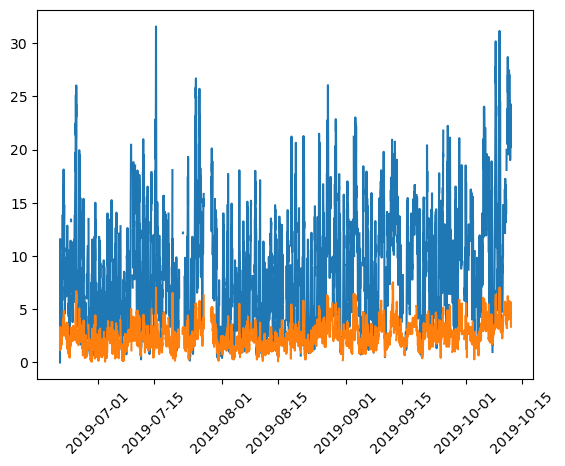

In [308]:
#Plot calculated and measured wind speed at top level

tower = 'PFb'

WS_calc = WS_top_calc(tower)
plt.plot(WS_calc)
plt.plot(WS_top[tower])
plt.xticks(rotation = 45);


In [305]:
H_ad, LE_ad = hrz_ad_calc('PFe')

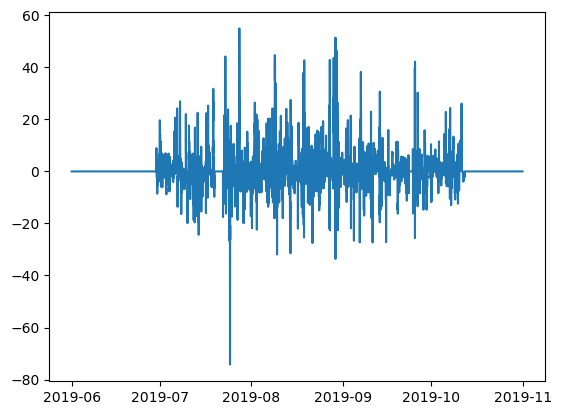

In [306]:
plt.plot(H_ad)

In [ ]:
#Top only

# #H and LE advection calcs

# def hrz_ad_calc(tower):

#     #Read in data
#     df = pd.read_csv(tc.org_path.loc[tower])
#     df = df.applymap(lambda x: np.nan if x == -9999 else x)

#     #Add datetime index
#     dt_ts = pd.to_datetime(df['TIMESTAMP_START'], format = '%Y%m%d%H%M') 
#     df.set_index(dt_ts, inplace = True)

    
#     PA_Pa = df.PA_1_1_1*1000 #kPa to Pa **this is at top of tower(~400m), need PA val for 30m and below**
#     rho = mm*PA_Pa/df_TA_K.T/R #Dry air density at each tower [kg/m^3] **should probably use virtual temperature here** 
#     z = np.asarray(tc.z)[:, None] #Height of each tower


#     #H advection
#     H_SN = rho*z*cp*SN_wind*(T_i_S - T_i_N)/2000 #Advection of sensible heat by southerly wind [W/m^2]
#     H_WE = rho*z*cp*WE_wind*(T_i_W - T_i_E)/2000 #Advection of sensible heat by westerly wind [W/m^2]
#     H_ad = H_SN + H_WE #Total advection

#     #LE advection
#     LE_SN = z*L*SN_wind*(H2O_i_S - H2O_i_N)/2000 #Advection of latend heat by southerly wind [W/m^2]
#     LE_WE = z*L*WE_wind*(H2O_i_W - H2O_i_E)/2000 #Advection of latent hear by westerly wind [W/m^2]

#     LE_ad = (LE_SN + LE_WE)*rho/rho #LE advection (the *rho/rho just makes it a df with the same tower and timestamp as indices)


#     hrz_ad = (H_ad + LE_ad).T
#     #Deal with water vapor later
#     # md_w = e/(R*TA_K) #Molar density of water vapor [mol/m^3], used in SLE calc

## Code Graveyard

PFb
PFc
PFd
PFe
PFg
PFh
PFi
PFj
PFk
PFl


C:\Users\emily\AppData\Local\Temp\ipykernel_17696\3923260543.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_mon = df.groupby([df.index.month, df.index.time]).mean()


PFm
PFn
PFp
PFq
PFr
PFs
PFt


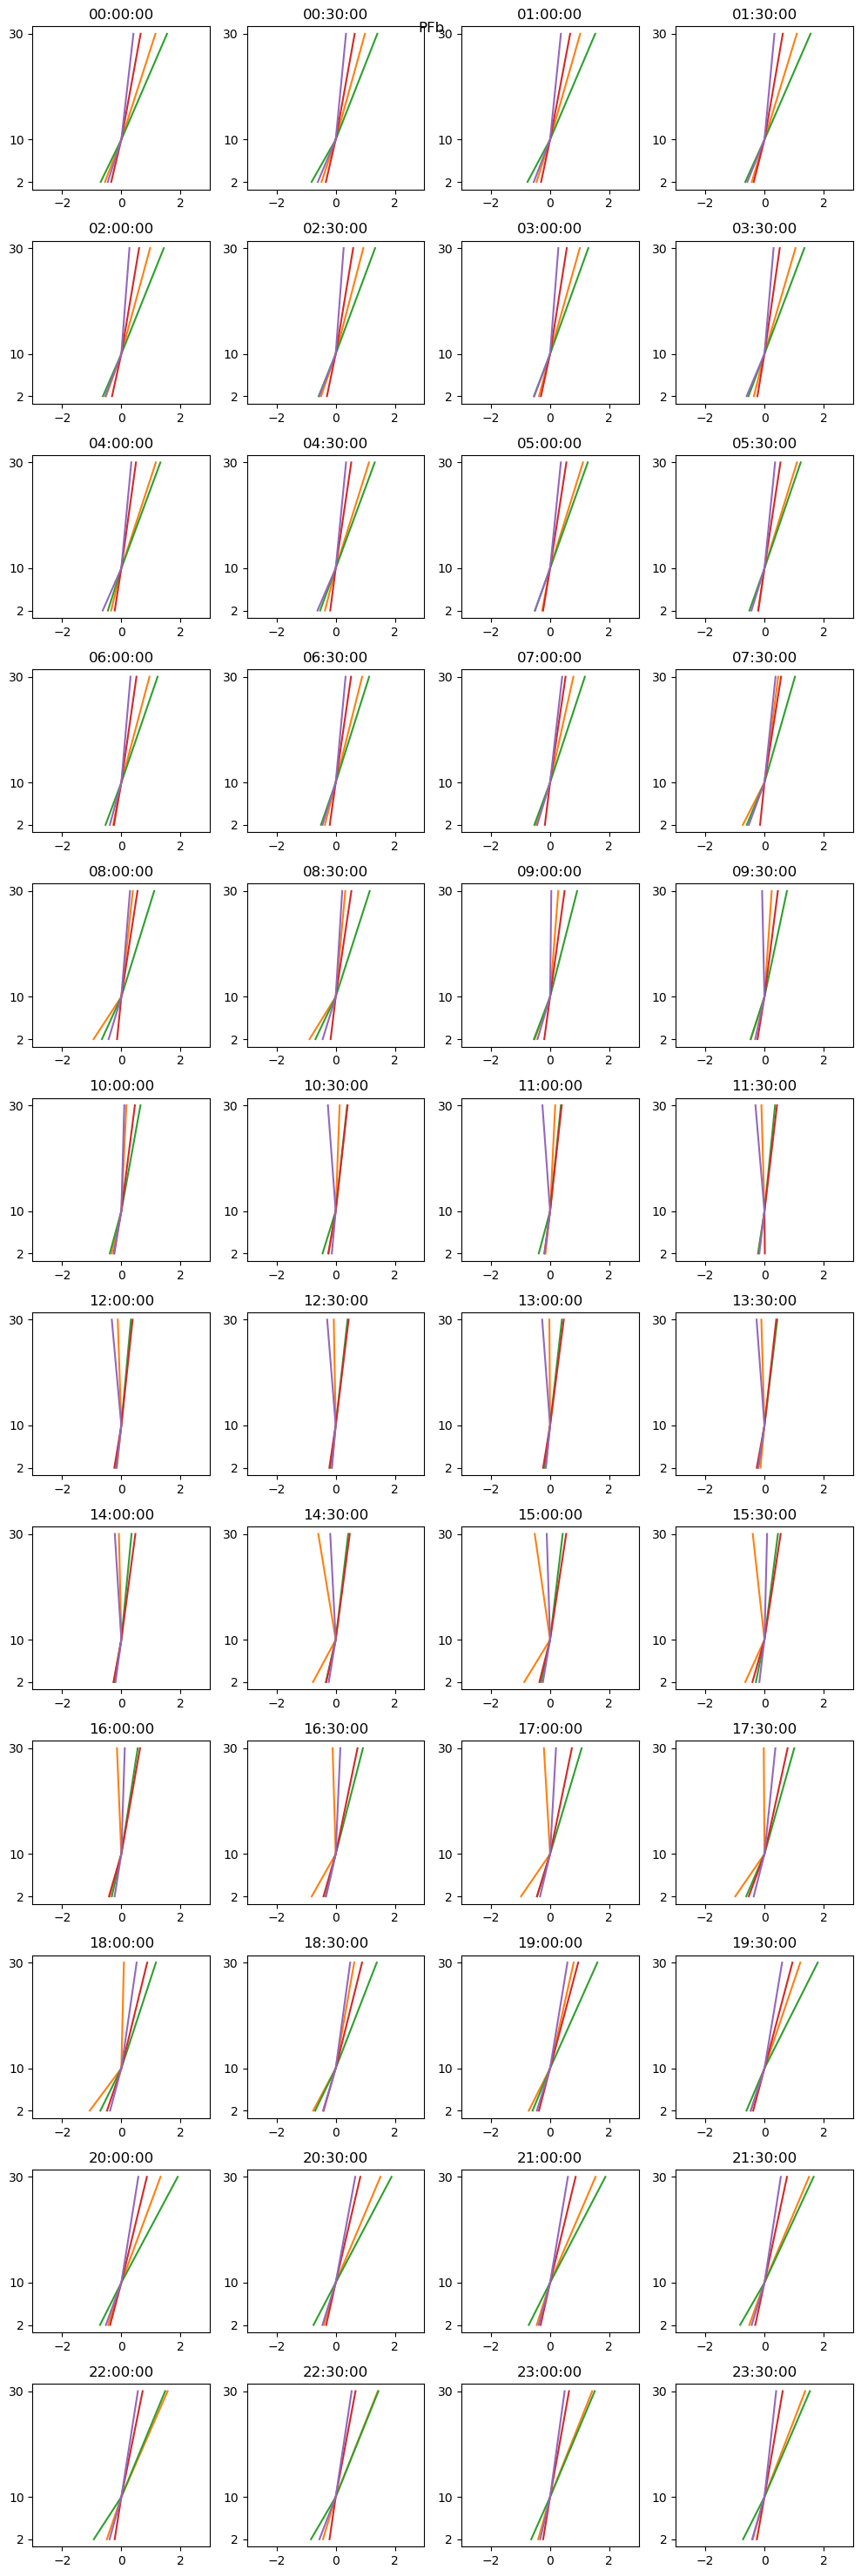

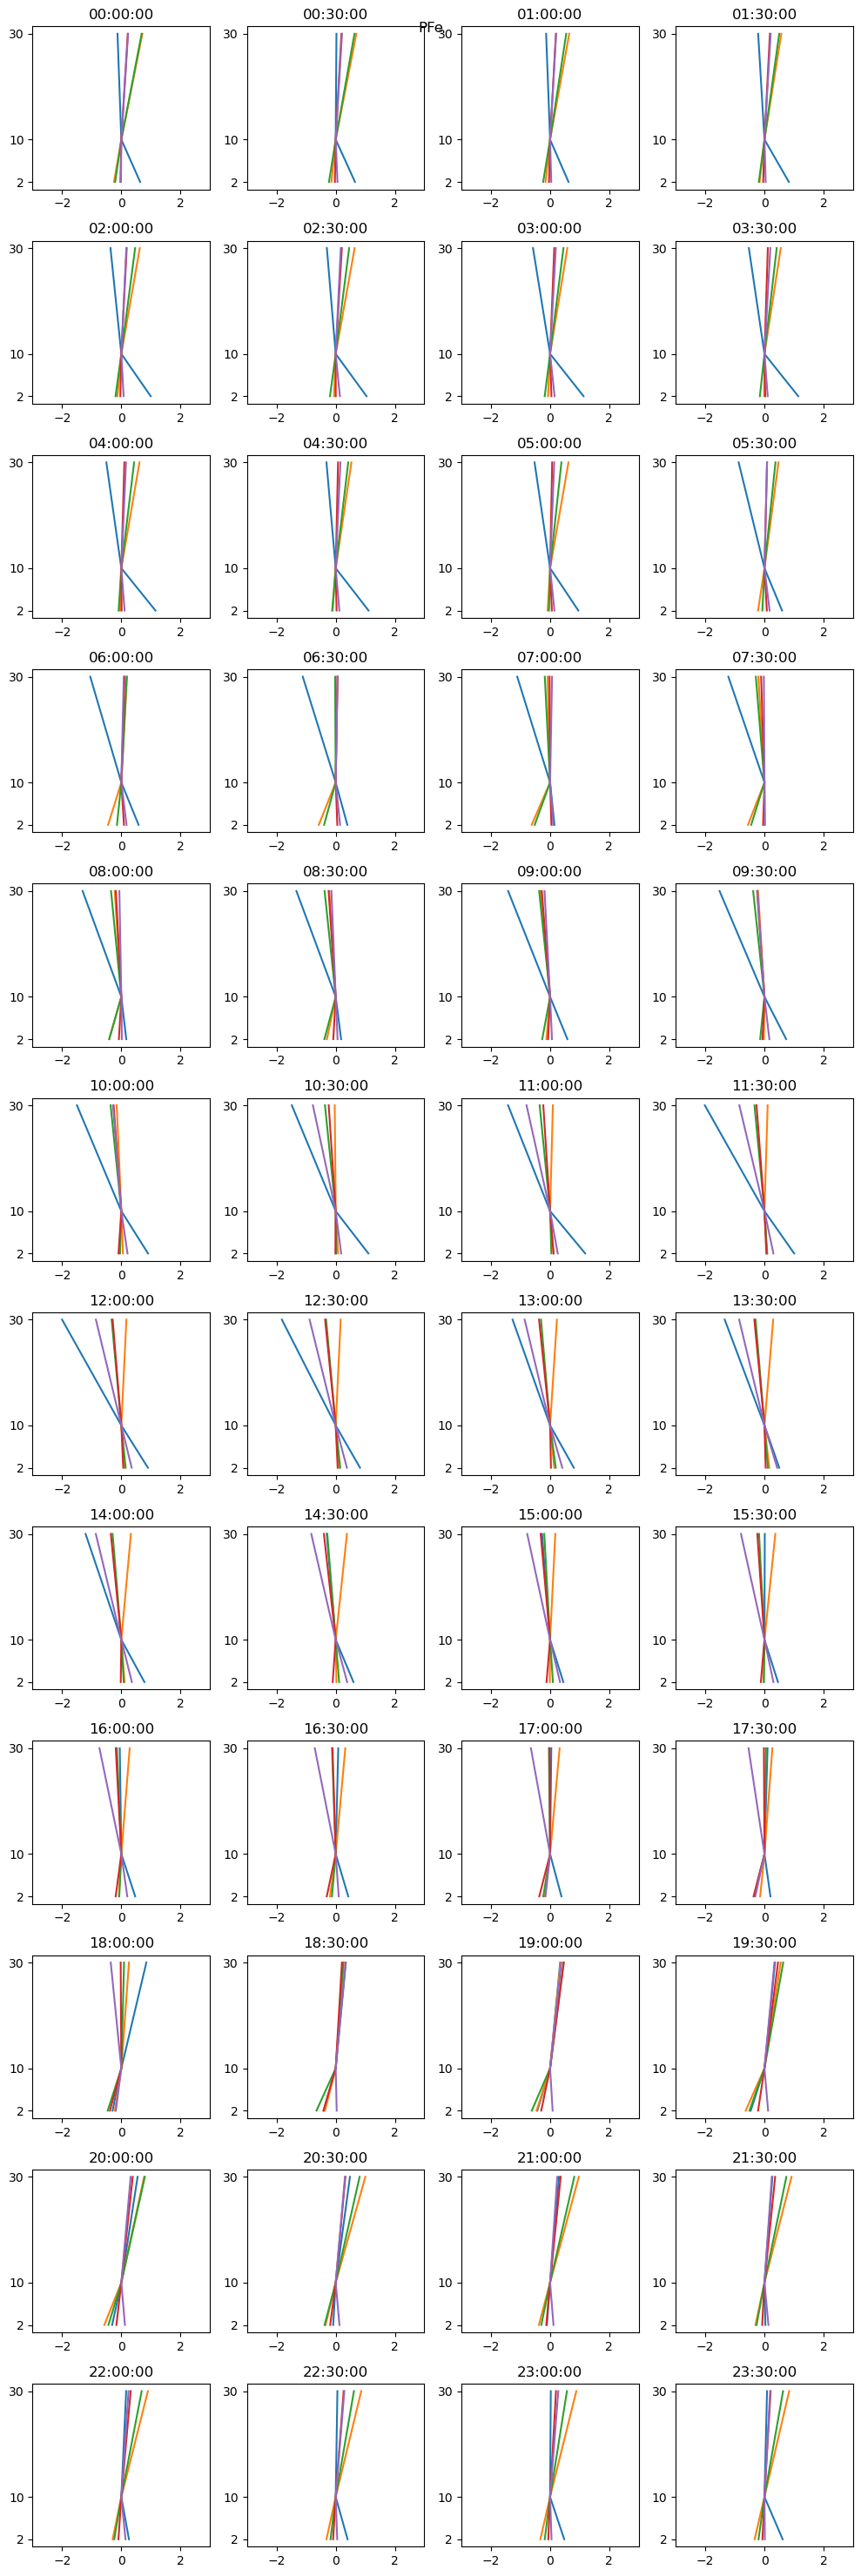

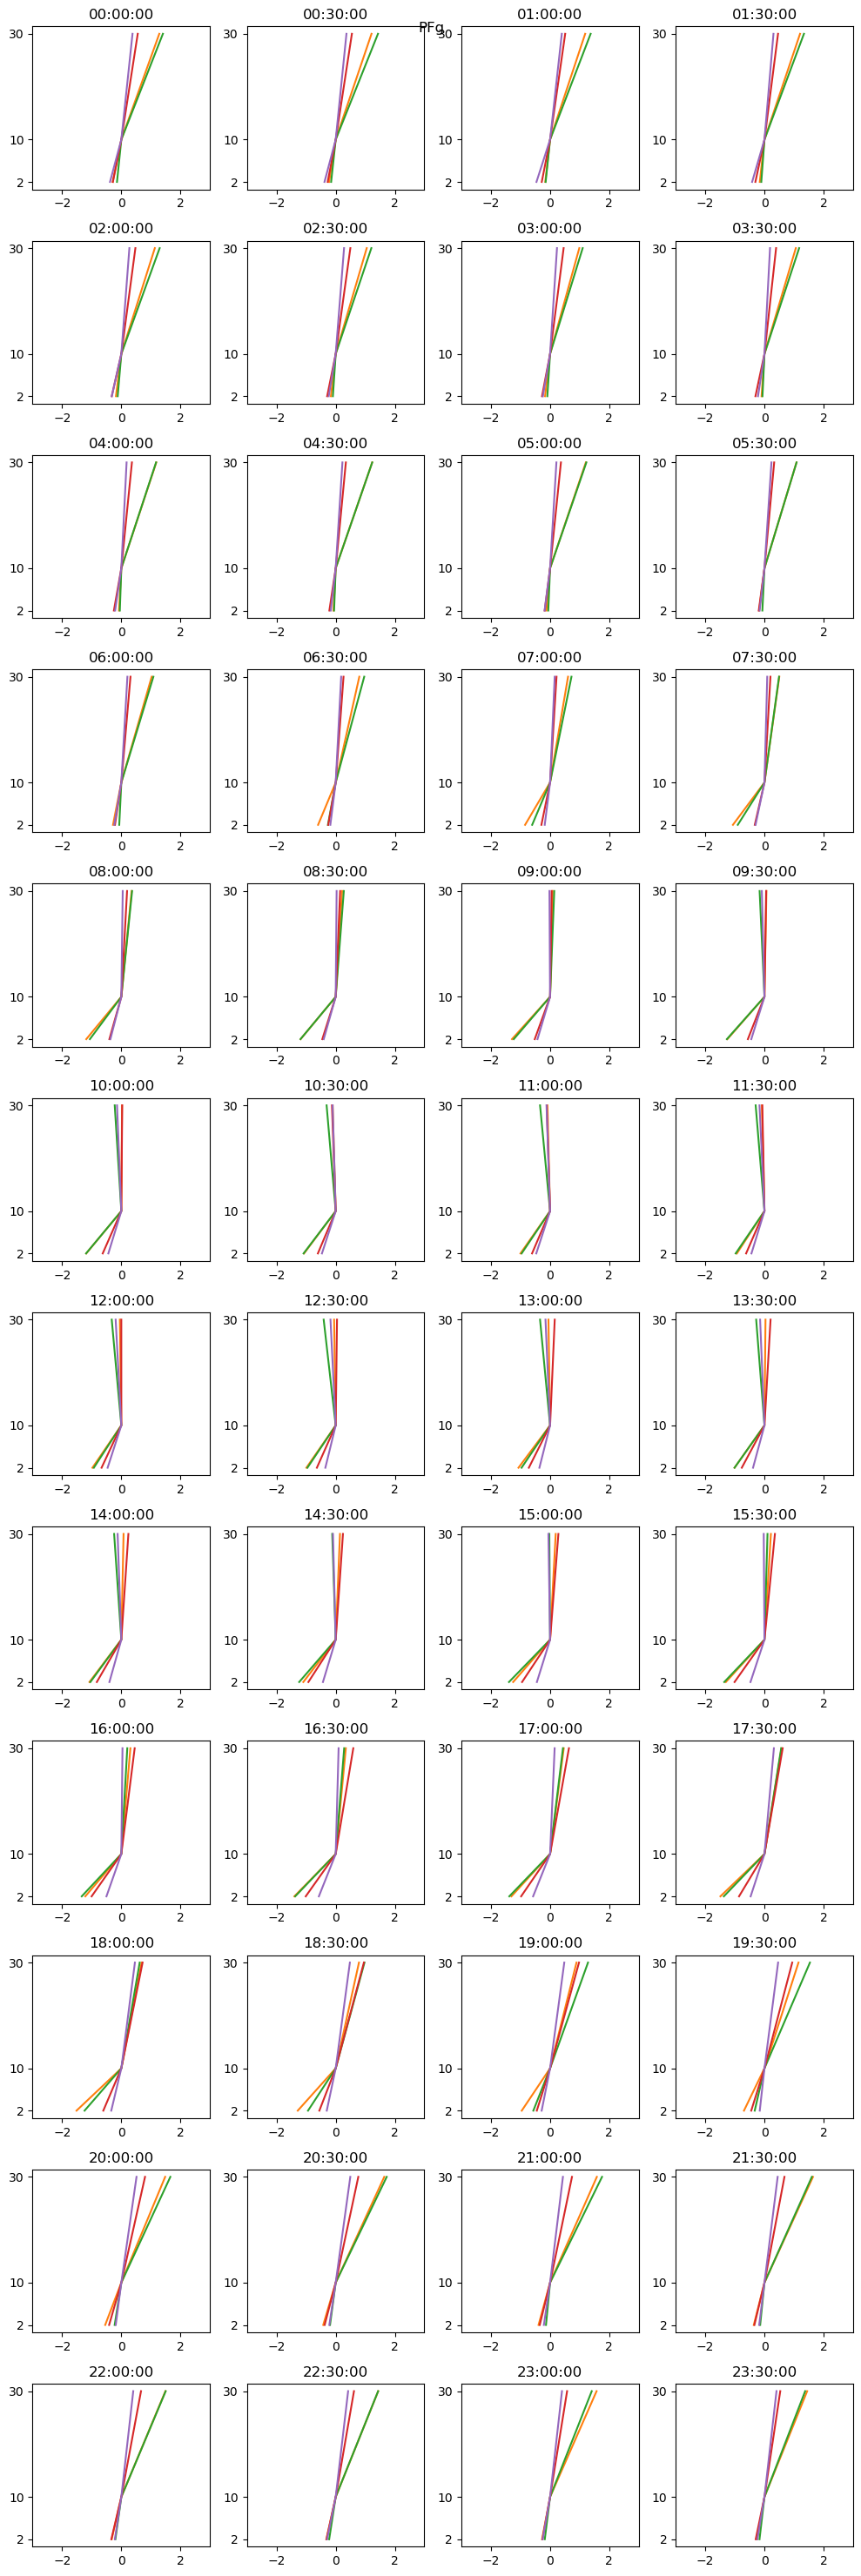

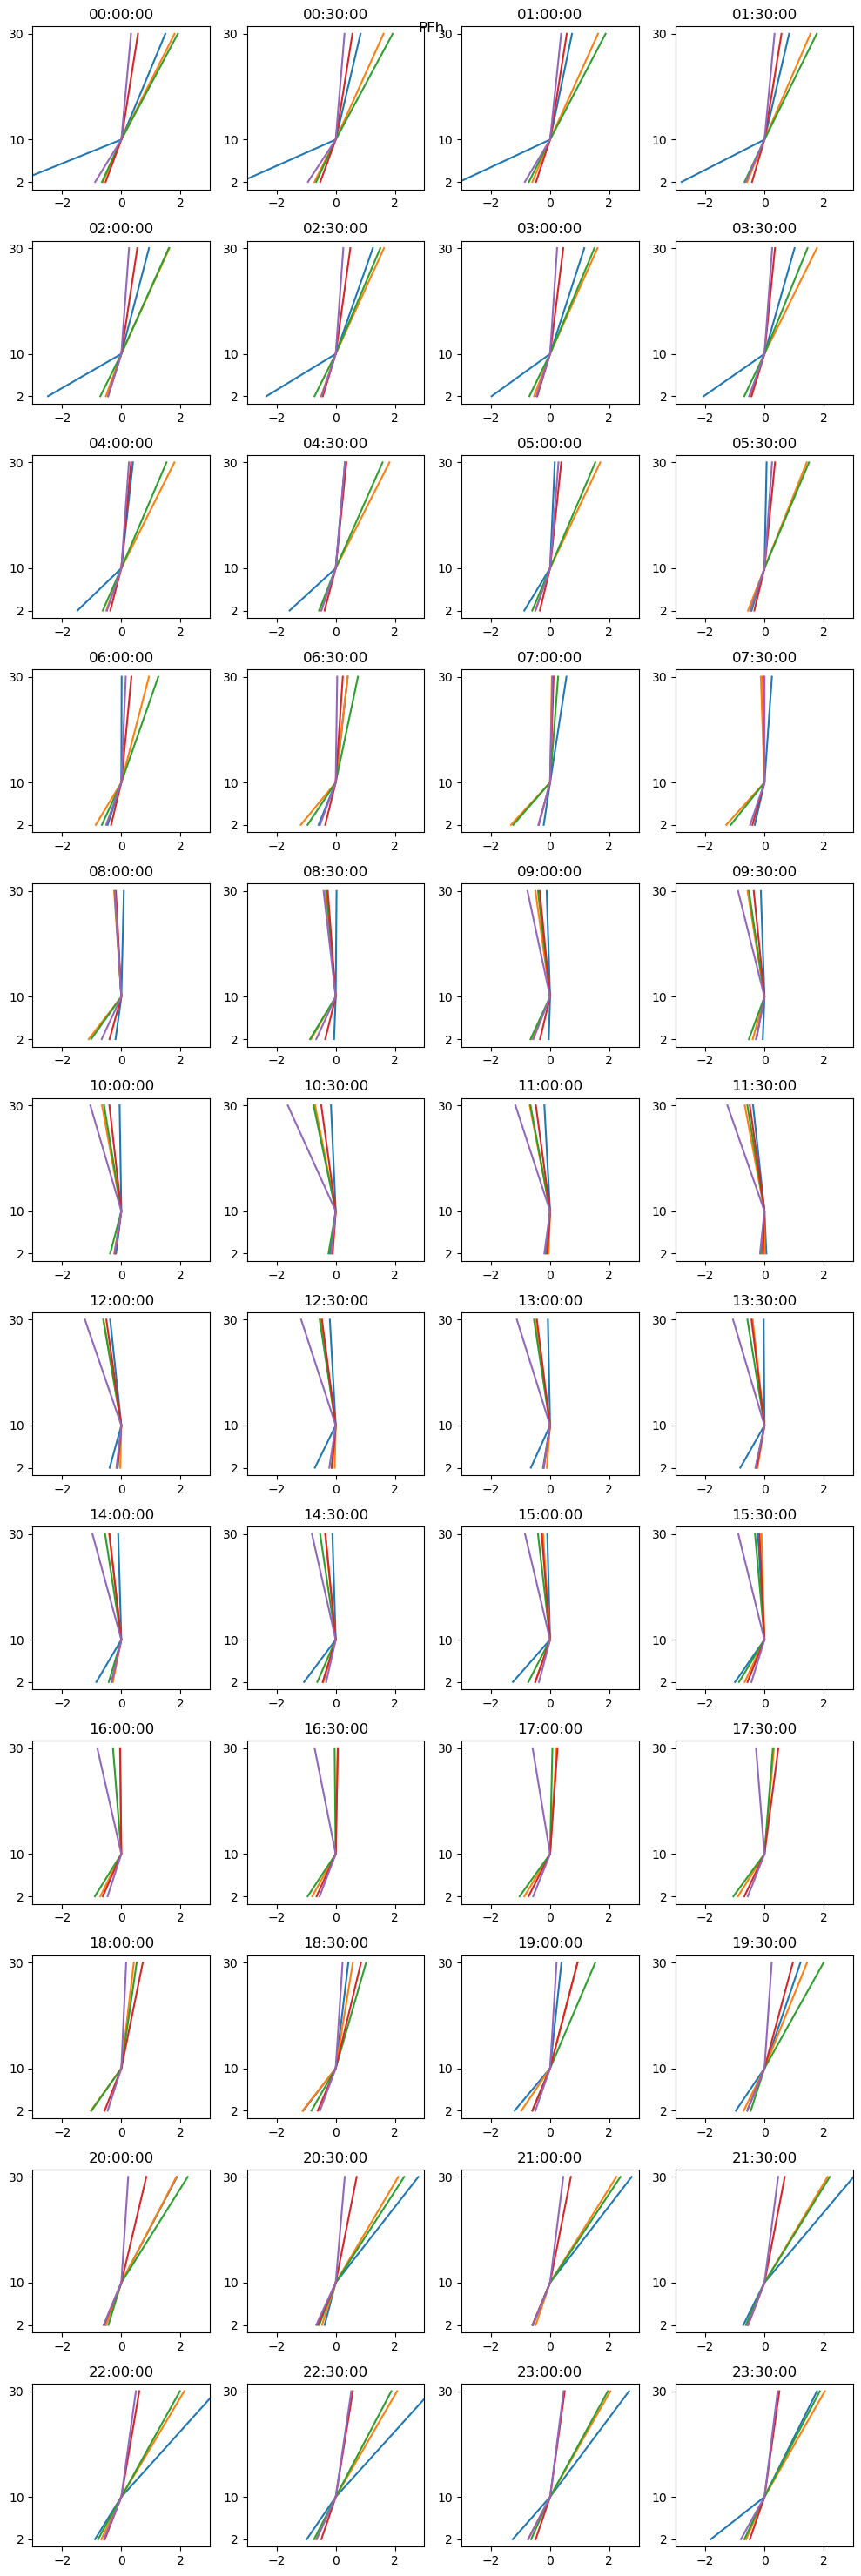

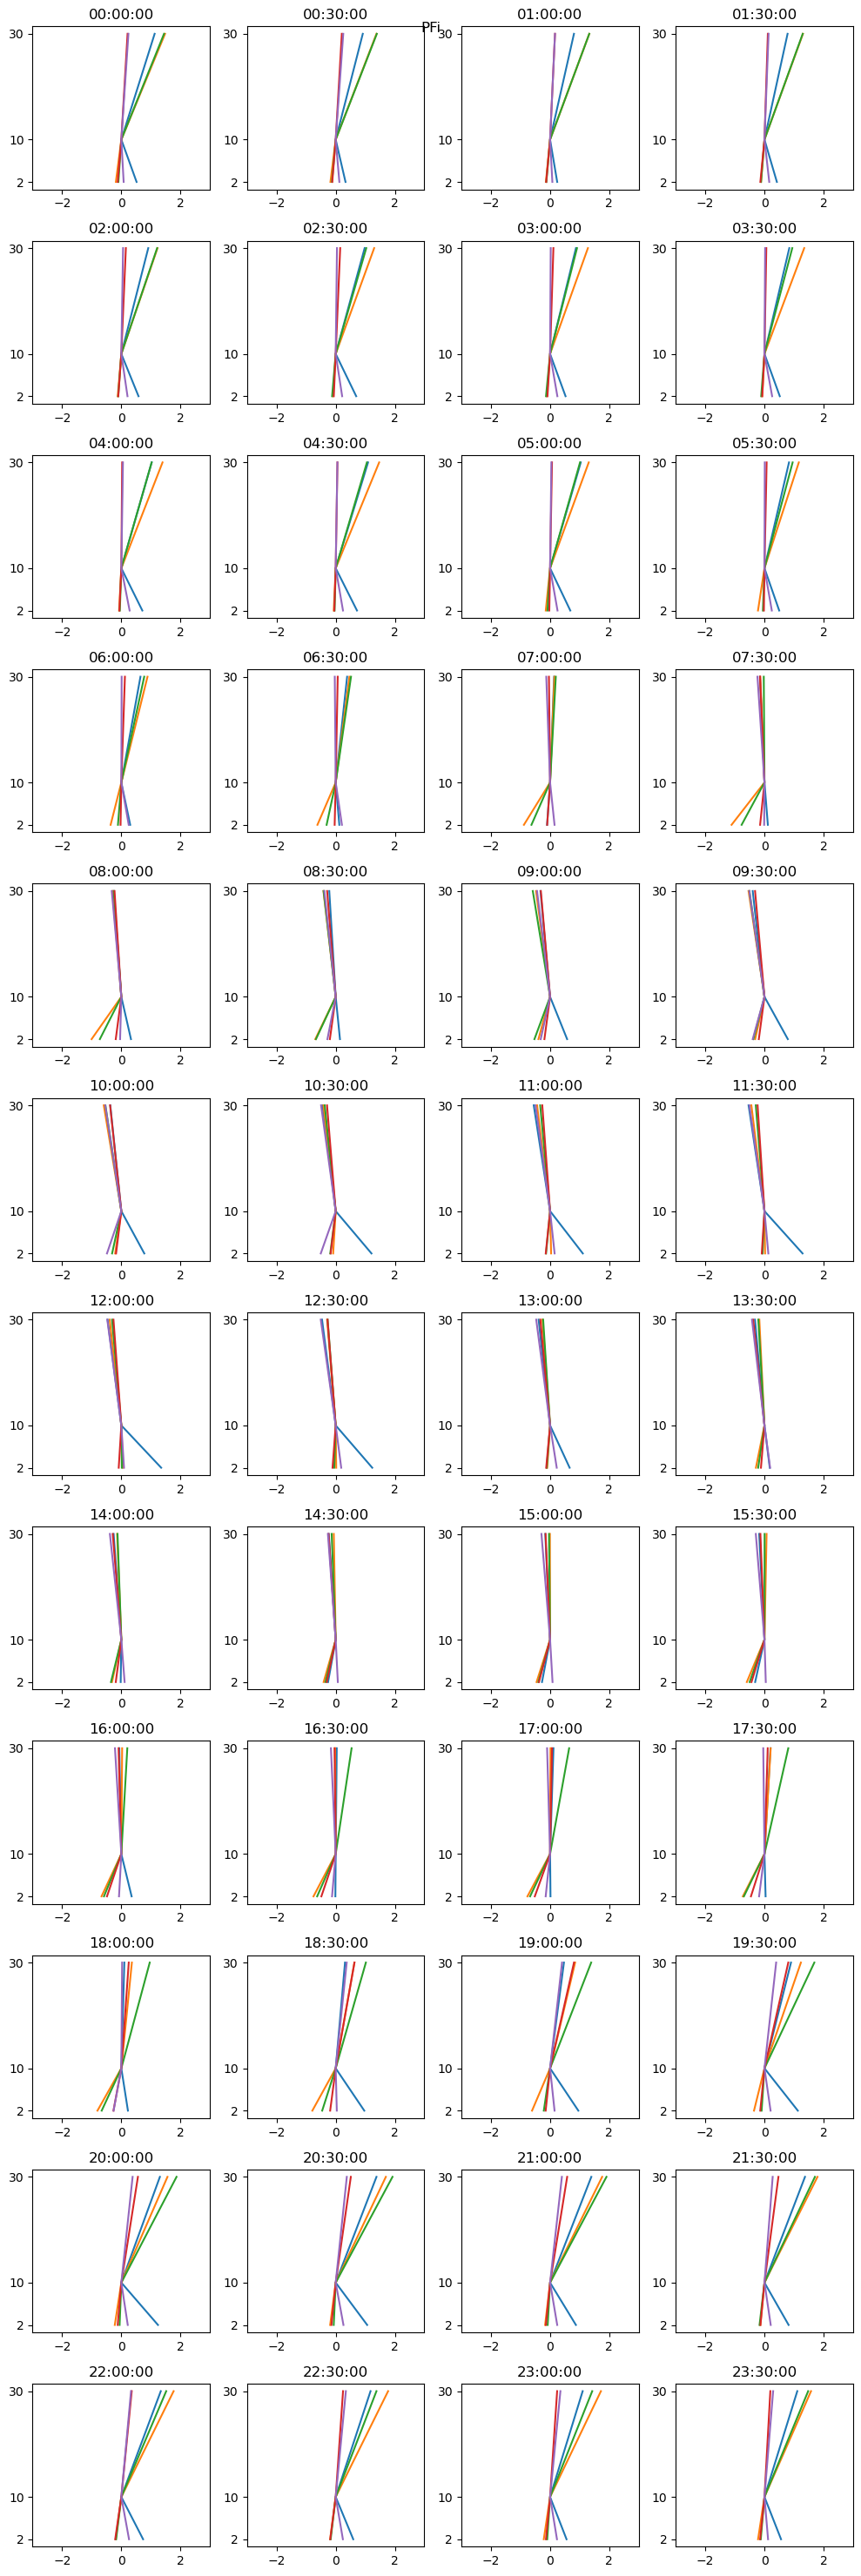

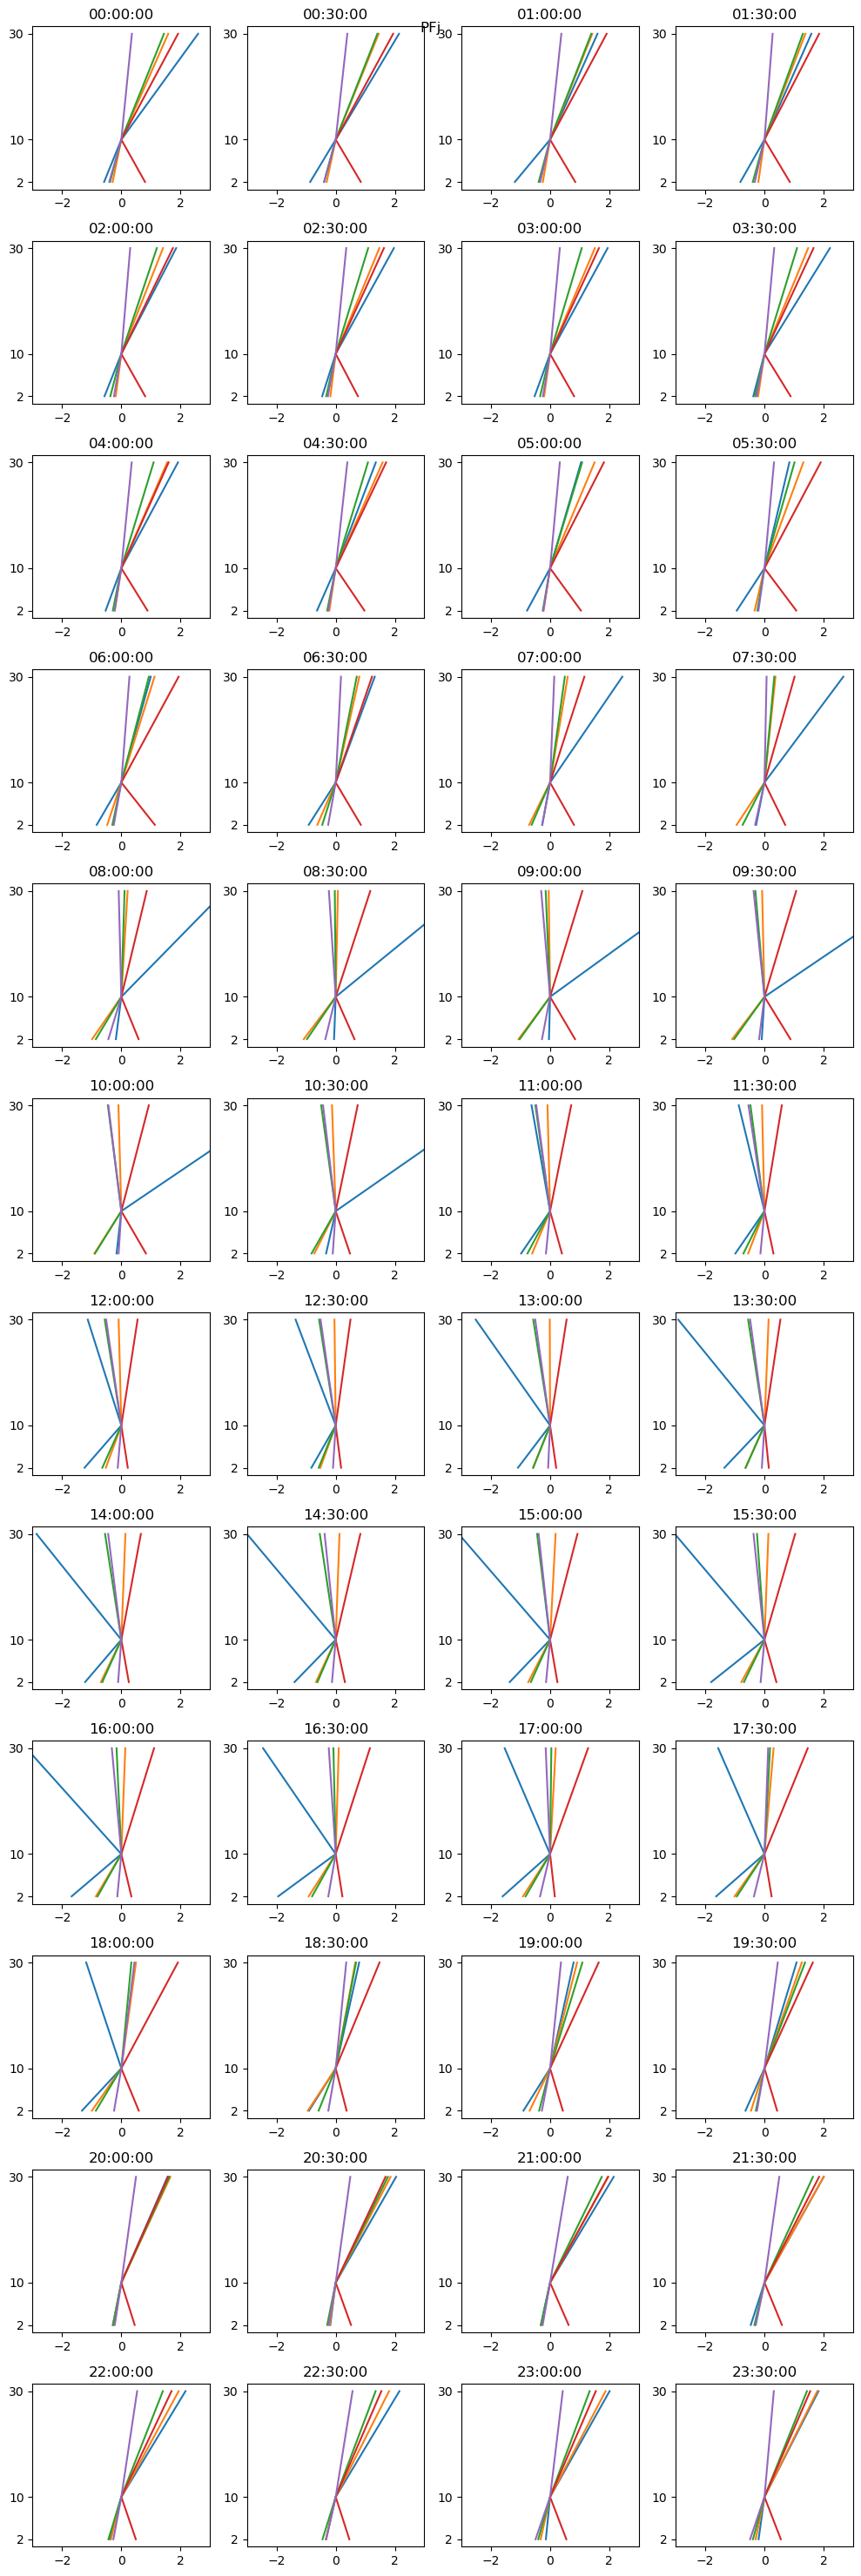

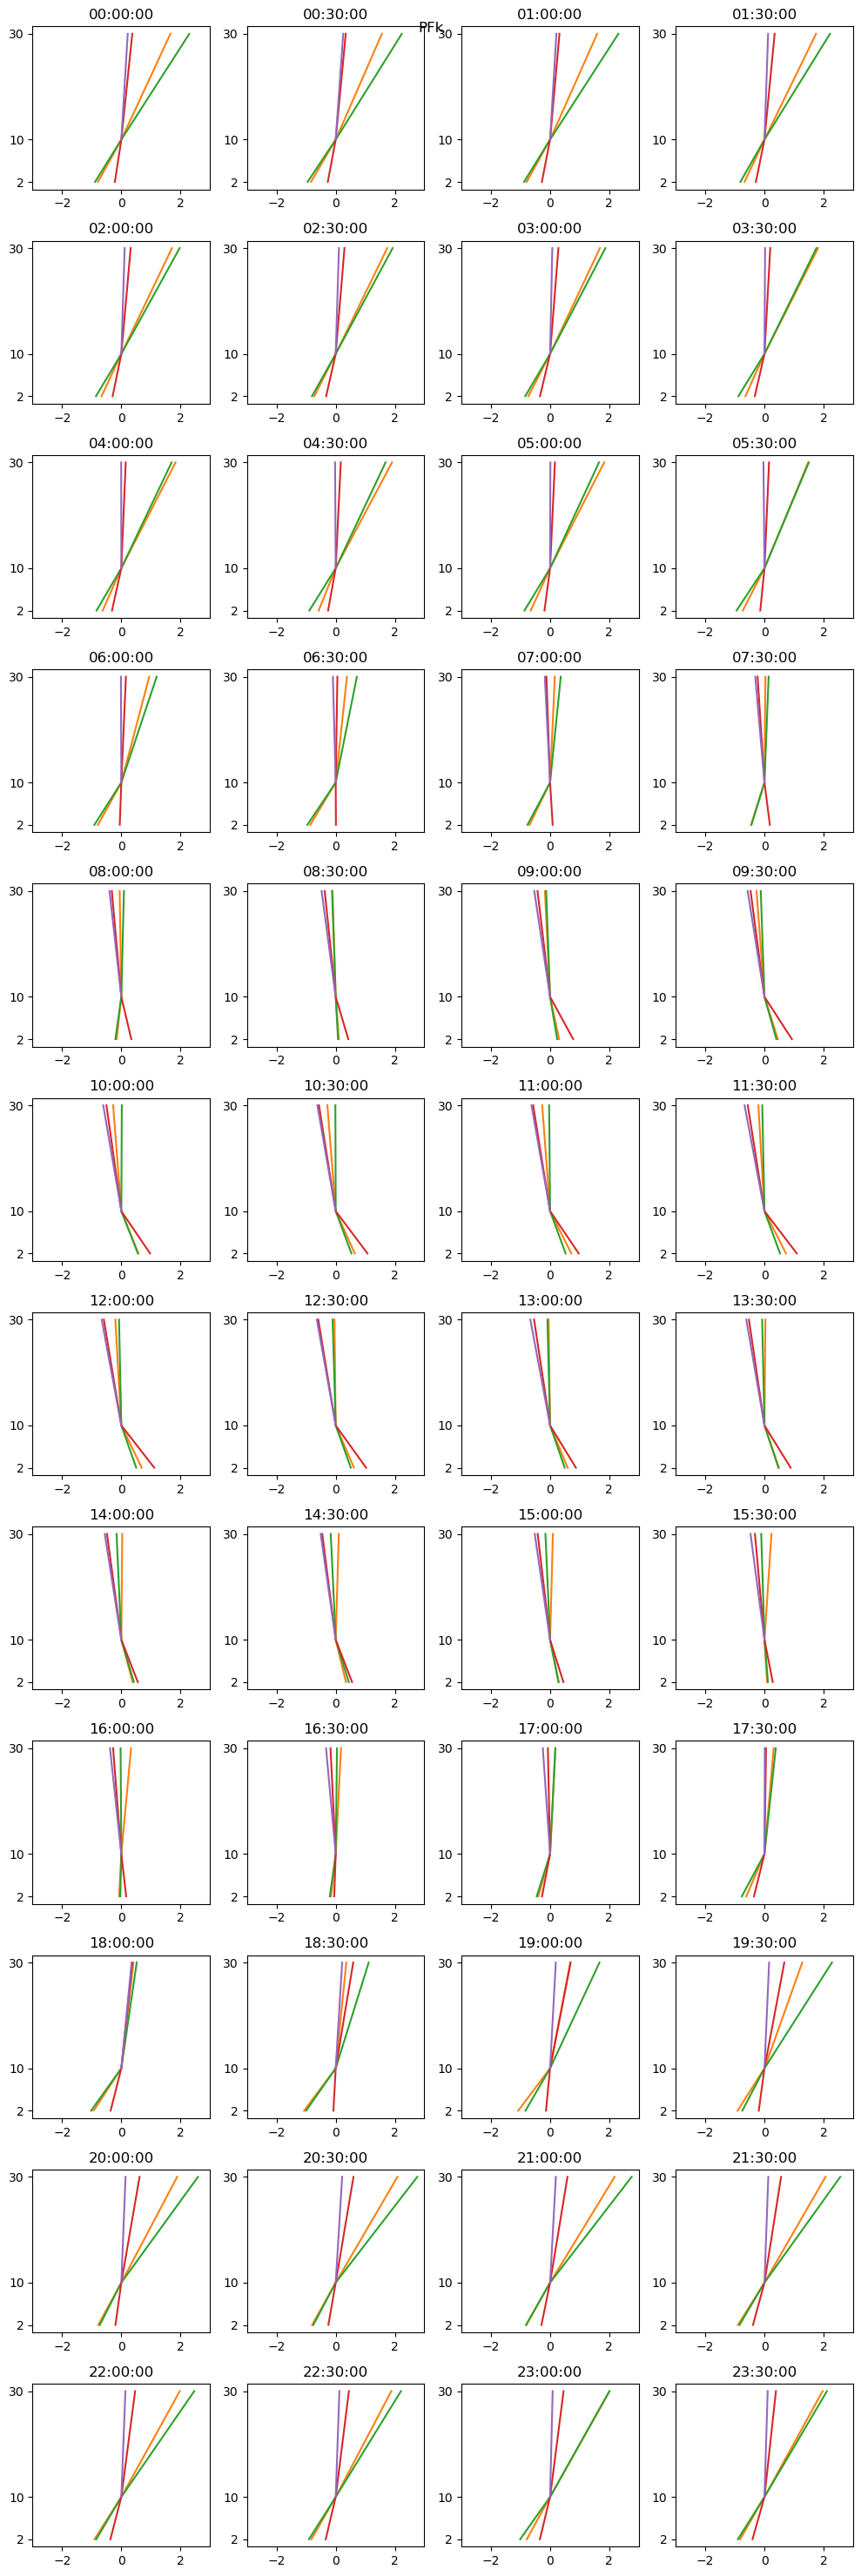

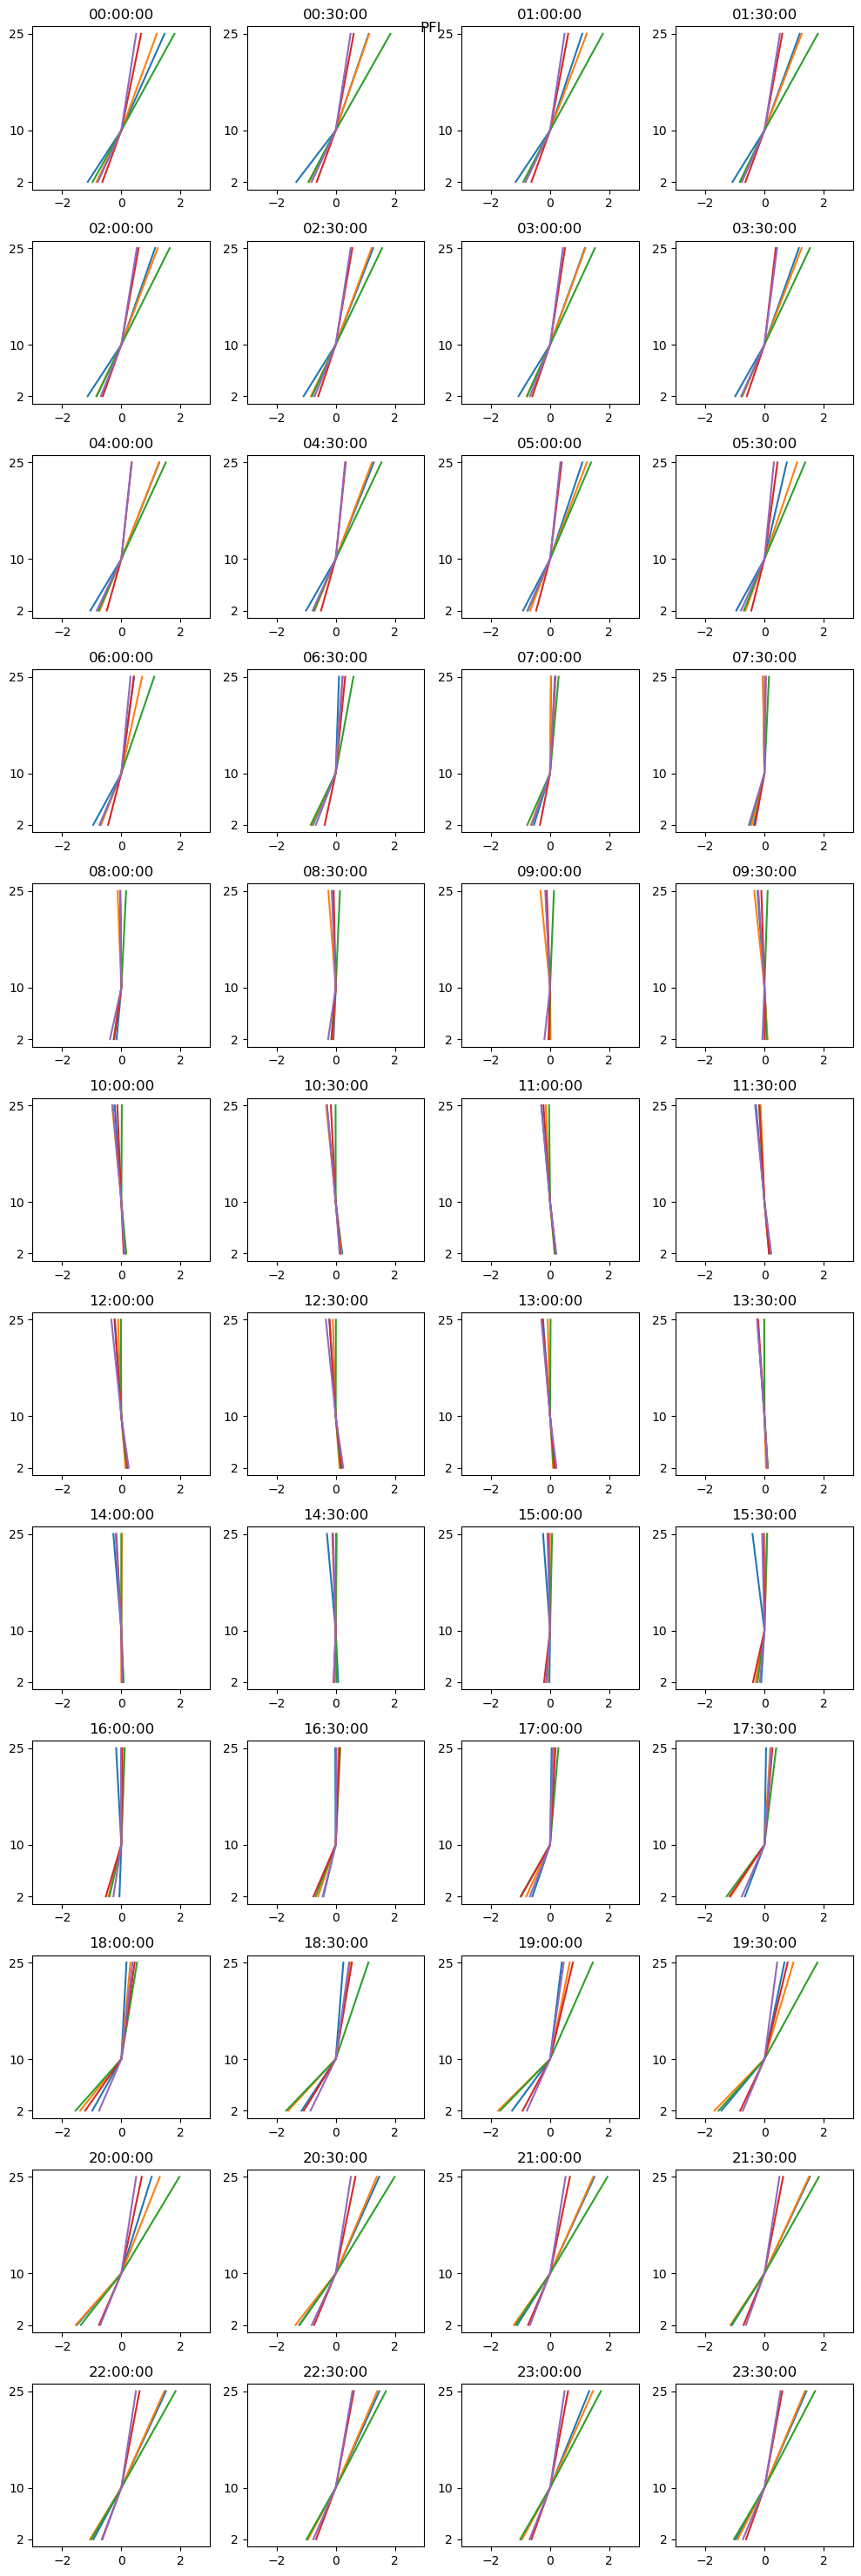

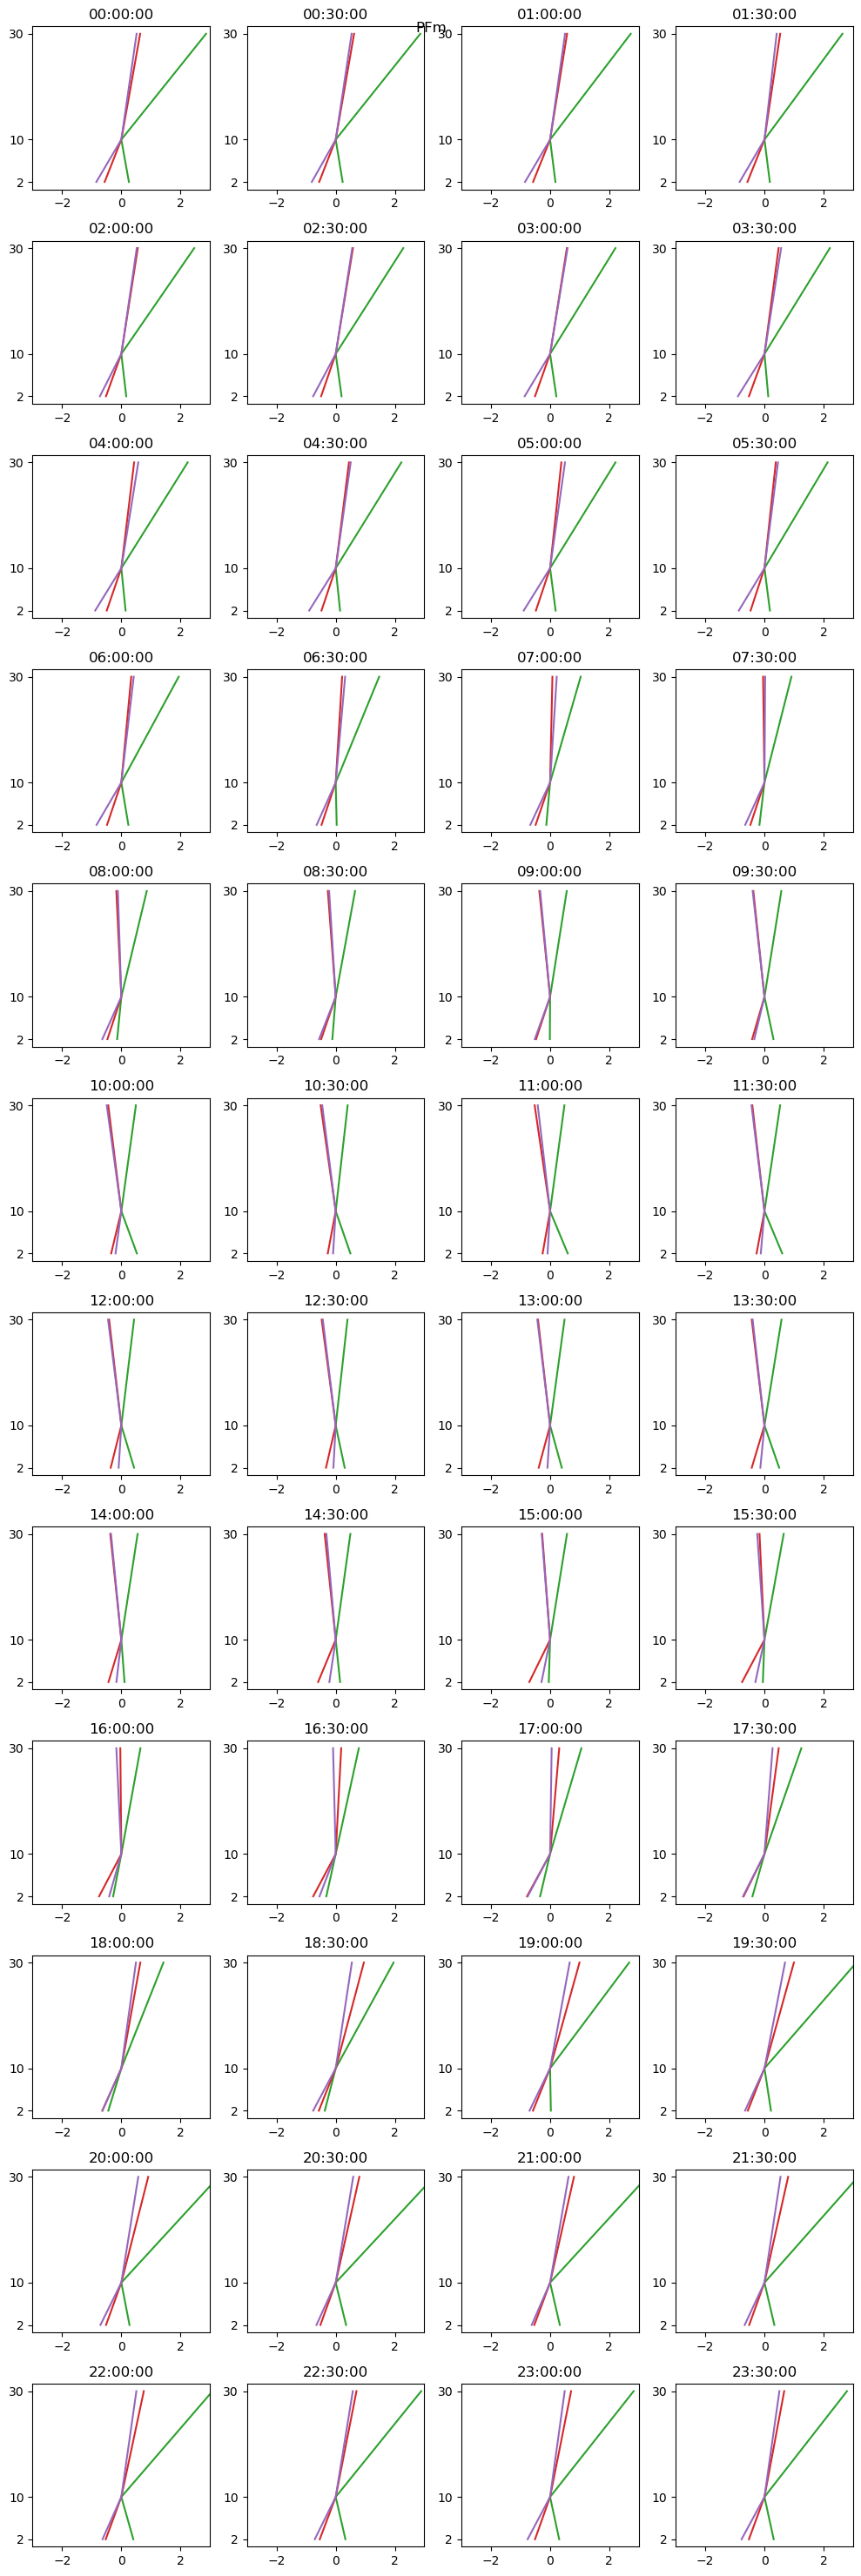

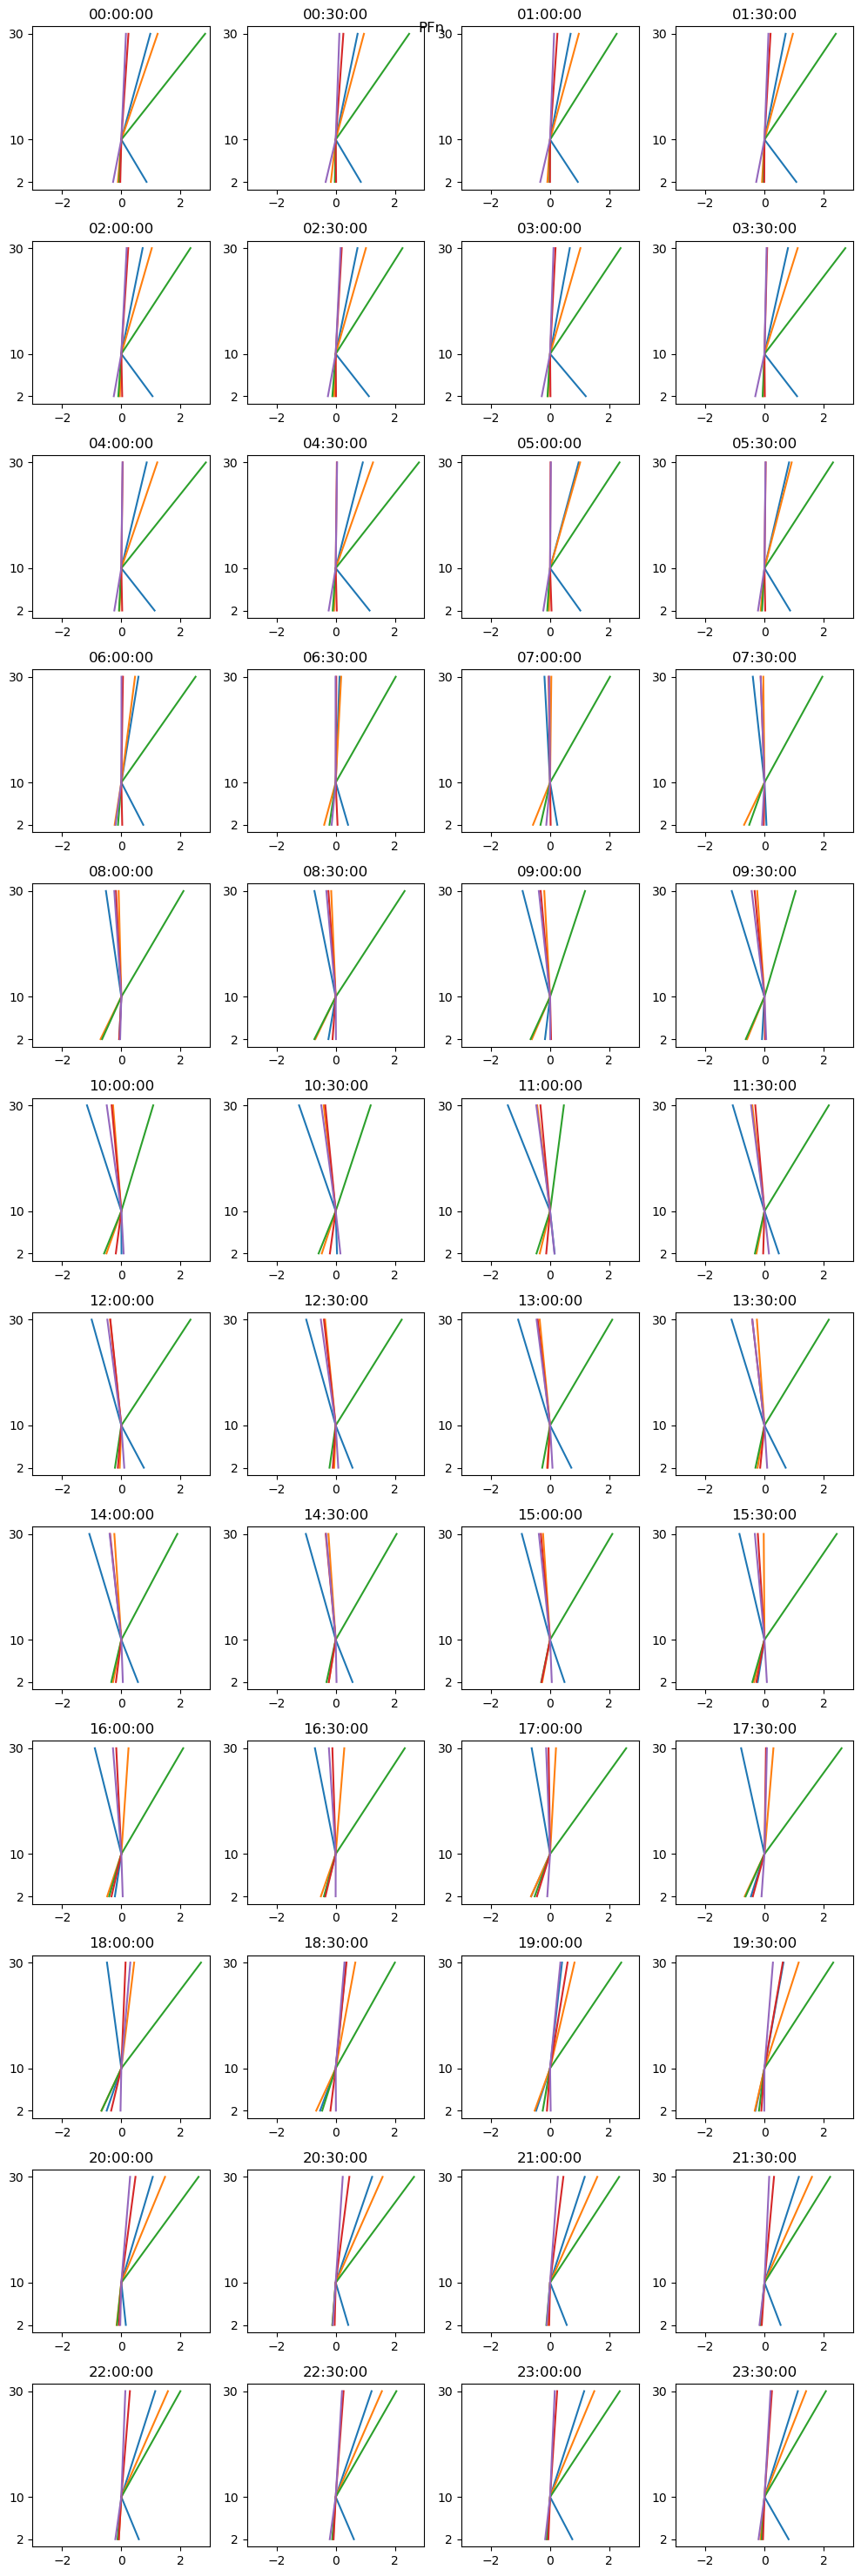

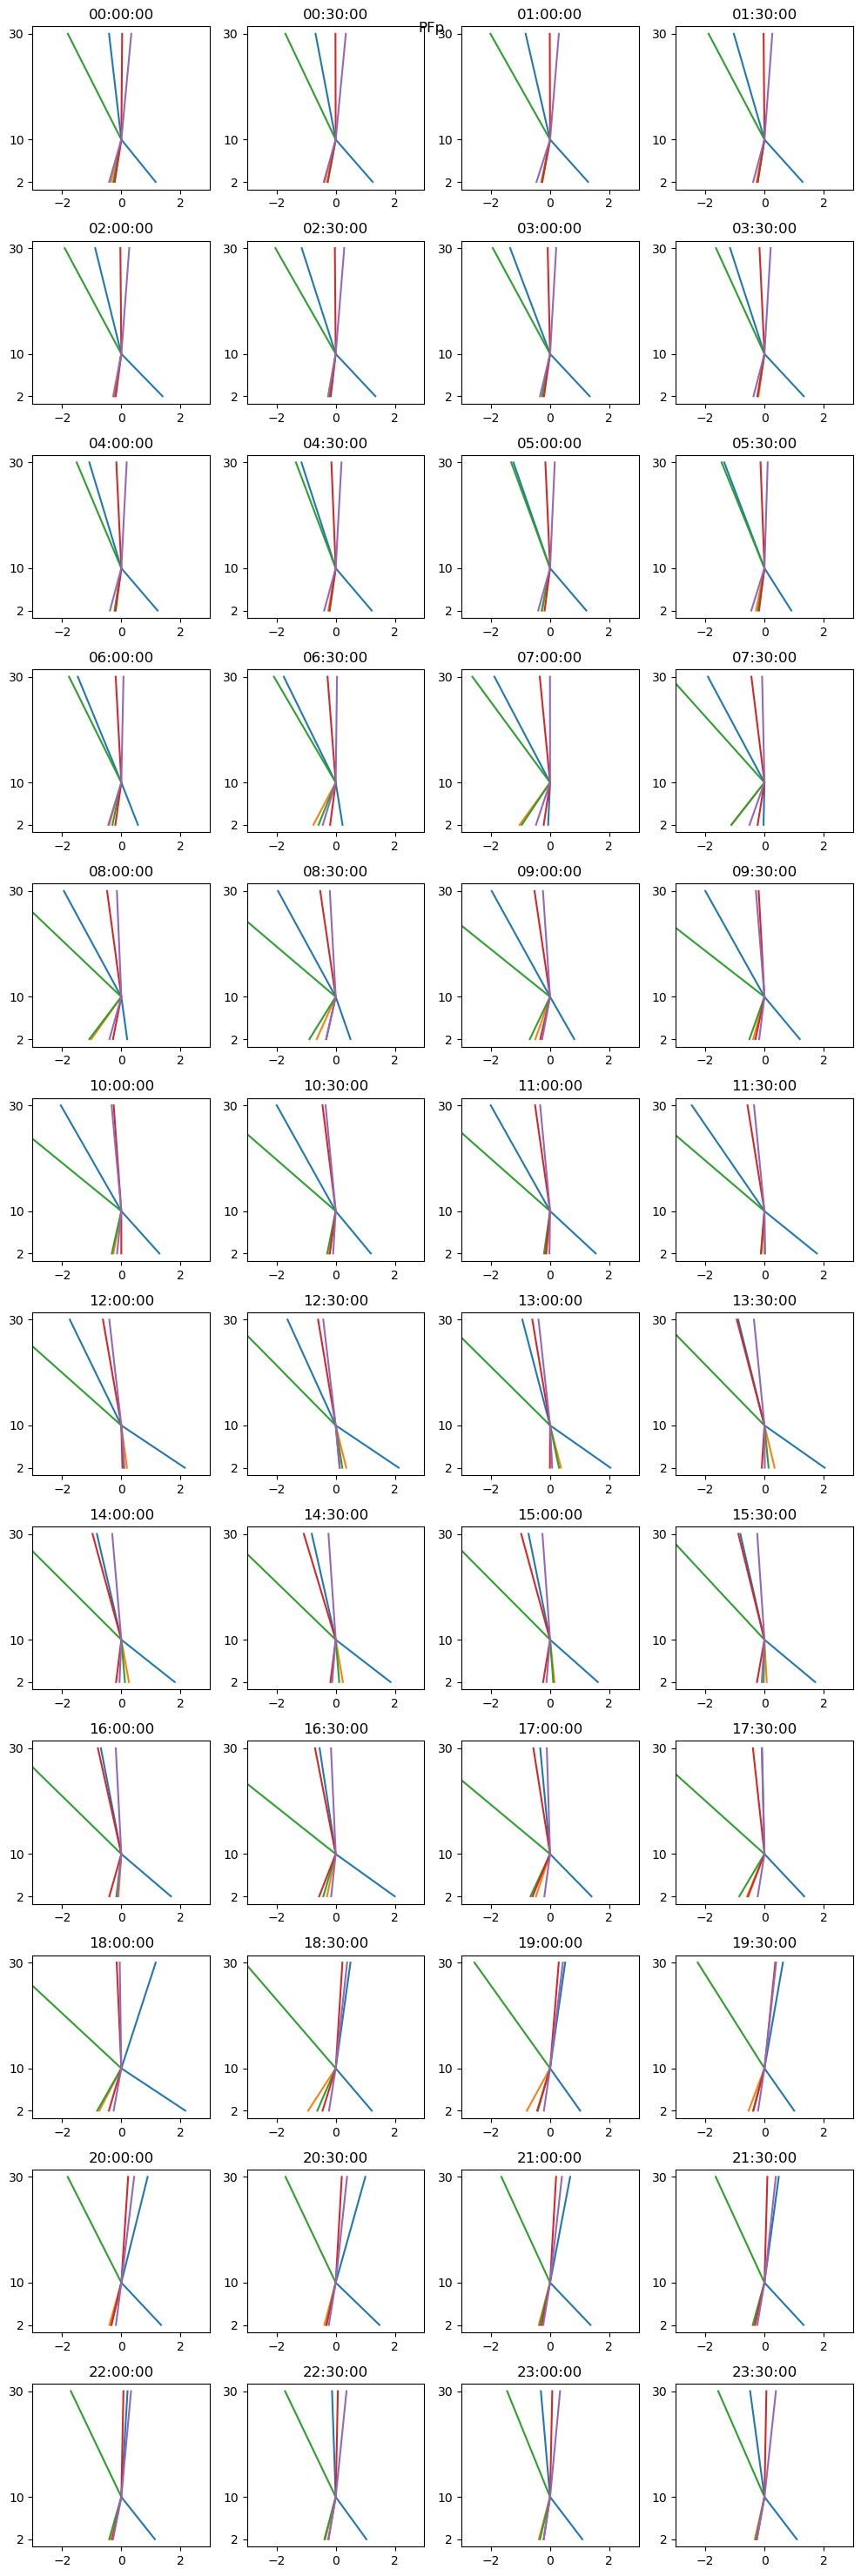

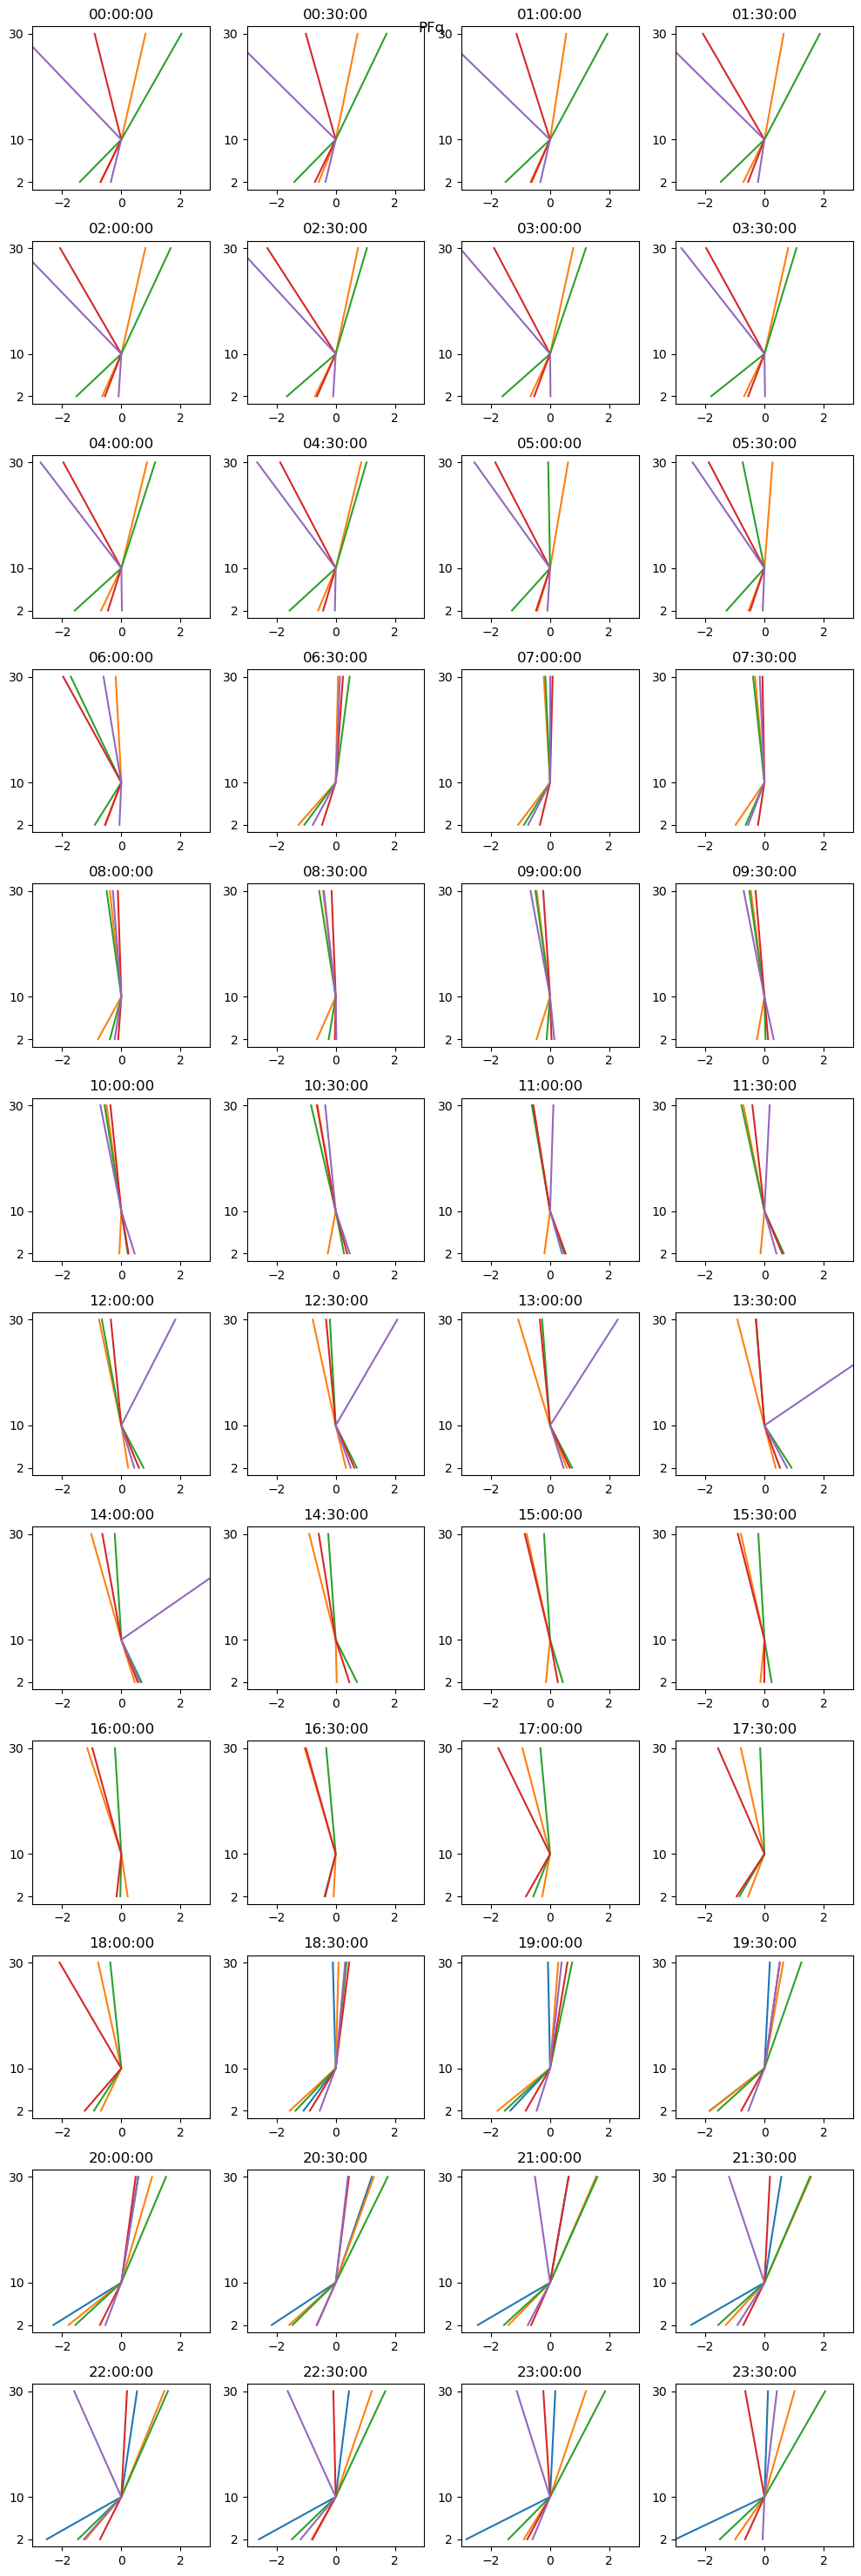

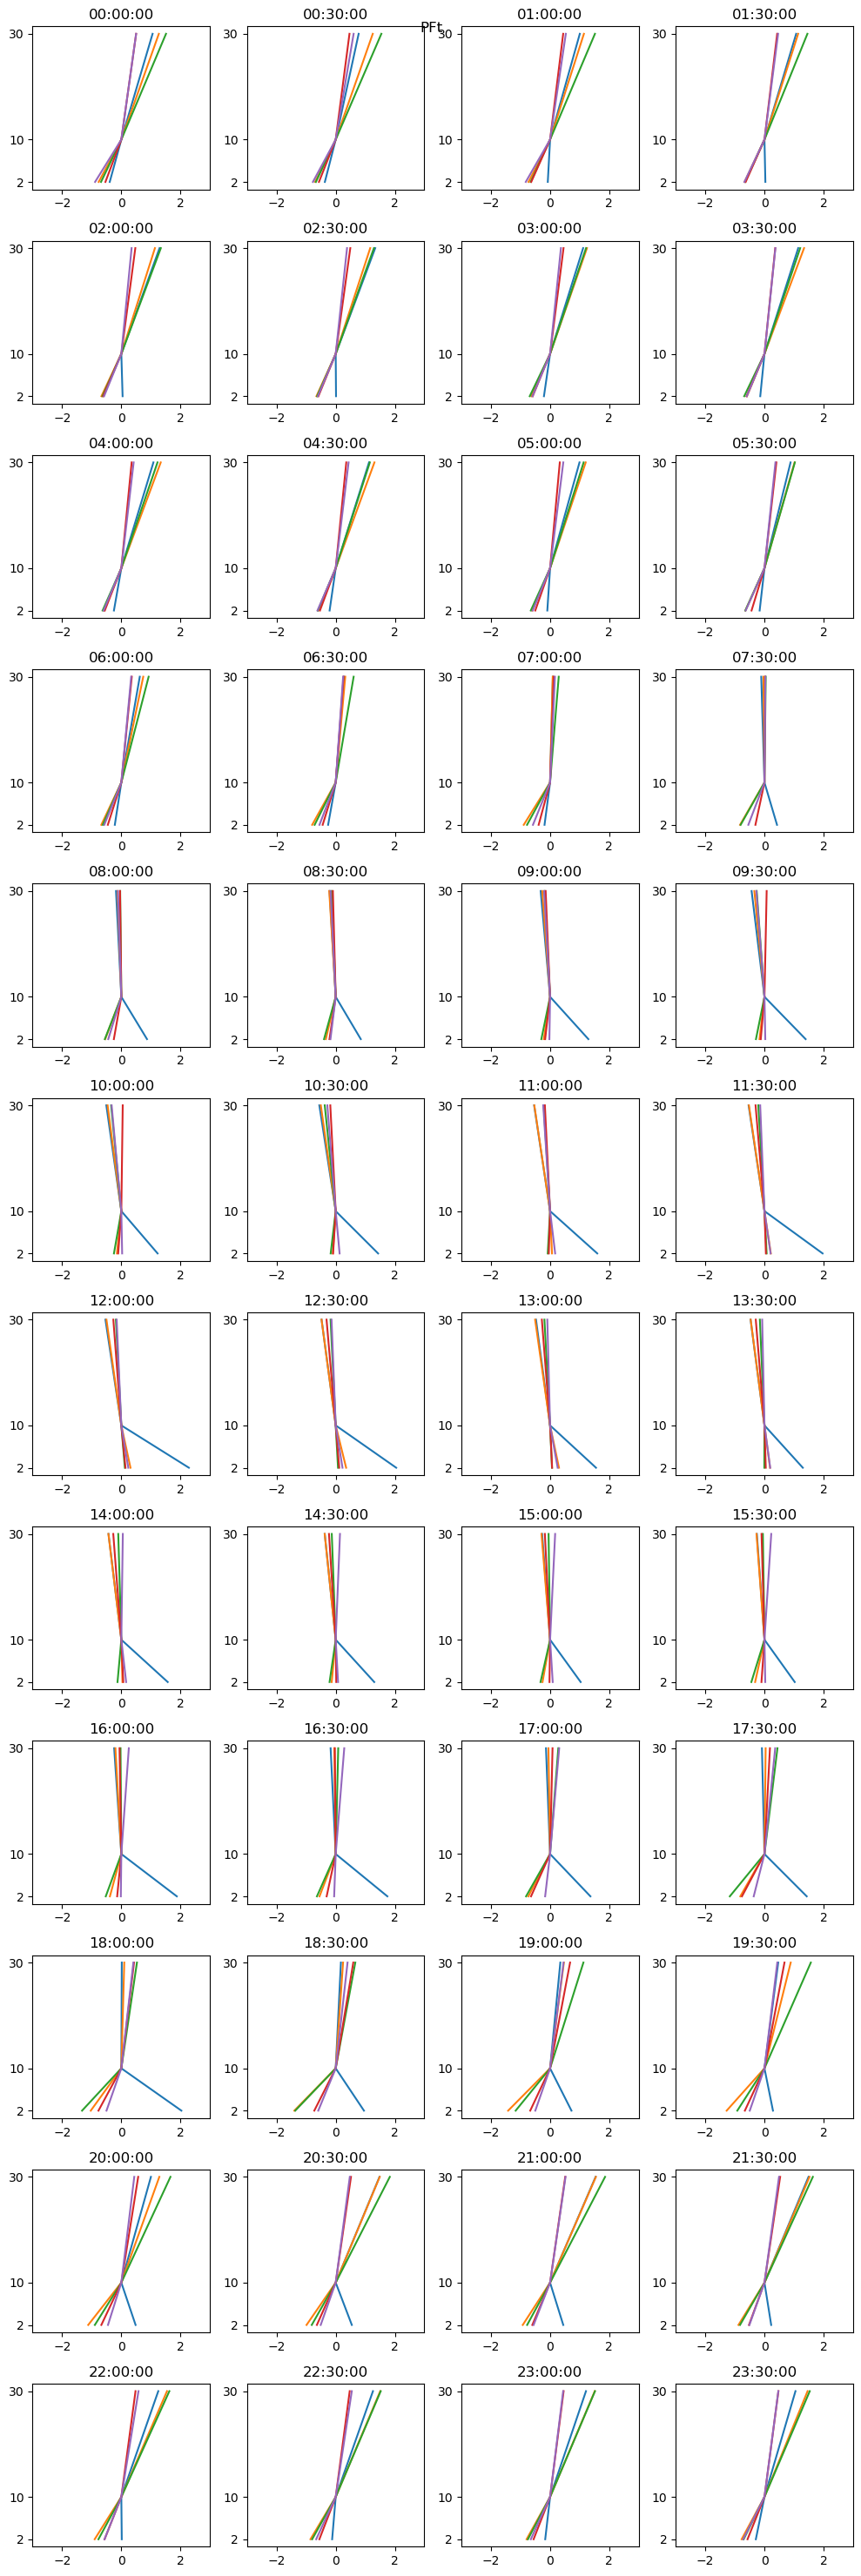

In [5]:
# #Code for plotting T profiles
# # plt.plot(df_mon.TA_1_1_1)

# for tower in tc.index:
#     if tower == 'PFA':
#         pass
    
#     else:
#         print(tower)
#         towdat = tc.loc[tower] #Tower data
#         filepath = towdat.org_path
#         df = pd.read_csv(filepath)
#         df = df.applymap(lambda x: np.nan if x == -9999 else x)

#         #Add datetime index
#         dt_ts = pd.to_datetime(df['TIMESTAMP_START'], format = '%Y%m%d%H%M') + dt.timedelta(minutes = 30) #half hour time stamp
#         df.set_index(dt_ts, inplace = True)
        
#         #Add TA_1_2_1 and TA_1_3_1 for shorter towers
#         # if towdat.z2 == 0:
#         #     df['TA_1_2_1'] = np.nan
#         if towdat.z3 == 0:
#             # df['TA_1_3_1'] = np.nan
#             pass
        
#         else:

#             df_mon = df.groupby([df.index.month, df.index.time]).mean()

#             fig, axs = plt.subplots(12, 4, figsize = (10, 30))
#             for mon in range(6, 11):
#                 # plt.plot(df_mon.TA_1_1_1[mon].values)
#                 i=0
#                 for hour in df_mon.TIMESTAMP_START[mon].index:
#                     ax = axs[i//4, i%4]
#                     i= i+1
                    
#                     TA_top = df_mon.TA_1_1_1[mon][hour] - df_mon.TA_1_2_1[mon][hour]
#                     TA_bottom = df_mon.TA_1_3_1[mon][hour] - df_mon.TA_1_2_1[mon][hour]

#                     # ax.plot([df_mon.TA_1_1_1[mon][hour], df_mon.TA_1_2_1[mon][hour],df_mon.TA_1_3_1[mon][hour]], [towdat.z1, towdat.z2, towdat.z3])
#                     ax.plot([TA_top, 0, TA_bottom], [towdat.z1, towdat.z2, towdat.z3])
#                     ax.set_yticks([towdat.z3, towdat.z2, towdat.z1])
#                     ax.set_title(hour)
#                     ax.set_xlim([-3, 3])

#                 fig.suptitle(tower)
#                 plt.tight_layout()
#                 plt.savefig(str('./Outputs/diff_Profiles/' + tower + '_TA_diff_profiles'))
# #Want to plot profile for each hour x = temperature, y = height
# #Could make 
# # for timme in df_day.index:
# #     profile = [



In [ ]:
'''
Taken from end of Interpfun
This bit of code was to add back in towers with nan values that were remobed above. Not needed since 
it is still possible to interpolate to the points N, S, E, and W of those towers without data from the 
towers themselve. However, maybe a good idea to remove those points since interpolation might not be as 
acurate without having data from a nearby point...something to consider
'''

# nan_inds = np.where(nanmask == False)[0] - np.arange(0 ,len(np.where(nanmask == False)[0]))

# dat_N.loc[dat_N.index ==i] = np.insert(dat_N_nn, nan_inds, np.nan)
# dat_S.loc[dat_S.index ==i] = np.insert(dat_S_nn, nan_inds, np.nan)
# dat_E.loc[dat_E.index ==i] = np.insert(dat_E_nn, nan_inds, np.nan)
# dat_W.loc[dat_W.index ==i] = np.insert(dat_W_nn, nan_inds, np.nan)

In [27]:
# df_test = pd.read_csv('http://co2.aos.wisc.edu/data/CHEESEHEAD-incoming/Ameriflux/US-PFb_HH_201906010000_201911010000.csv')